In [0]:
#Need block level since the activity data only cants the block keys and block ids

vertical_level_df = spark.sql('''
          select course_number, key as vertical_key, key_label as vertical_label, children as block_key
          from wgu_lakehouse.cgp_oex_course_structure.course_structure_flattened_all_courses
          where category = "vertical"''').persist()

vertical_level_df.createOrReplaceTempView('vertical_level')

In [0]:
#joining blocks into LAX team master lookup

int_wide_course_structure_df = spark.sql('''
                                         select a.*, b.block_key
                                          from wgu_analytics.lax_lookups.master_module_order_lookup a 
                                          join vertical_level b
                                          on a.page_id = b.vertical_key
                                          where a.vendor = "OEX"
                                          and a.OA_assessment_code != "null"''').persist()

int_wide_course_structure_df.createOrReplaceTempView('int_wide_course_structure')

In [0]:
#Creating a course structure of all units, modules, pages, and blocks that I can reference throughout

wide_course_structure_df = spark.sql('''
                                     select course_number, cversion as course_version, coursekey, unit_id, unit_title, unit_number, module_id, module_title, module_order, competency_code, oa_assessment_code, pre_assessment_code, page_id, page_title, page_number, block_key, split(block_key, '@')[2] as block_id --Some tables only have the block id so I Have to split at the '@' to just get the ID portions
                                      from int_wide_course_structure ''').persist()

wide_course_structure_df.createOrReplaceTempView('wide_course_structure')

In [0]:
#Not all tables have both IDs, so need to put those together (user_id is OEX specific and assigned when they create their OEX account. username is pidm)
#This should be available in a user table. Just needs to be migrated, I think.

user_id_lookups_df = spark.sql('''
                               select distinct user_id, username
                                from wgu_lakehouse.cgp_oex_events.goto_position''').persist()

user_id_lookups_df.createOrReplaceTempView('user_id_lookups')

In [0]:
#there are cases where a pidm has multiple IDs. Getting their largest (as I assume it is most recent) ID

max_person_id_df = spark.sql('''
                              select pidm, max(id) as max_id
                              from wgubi.person
                              group by pidm''')

max_person_id_df.createOrReplaceTempView('max_person_id')

In [0]:
#joining the recent ID back into the person table for details. 

recent_person_df = spark.sql('''
                             select a.*
                             from wgubi.person a
                             join max_person_id b
                             on a.pidm = b.pidm
                             and a.id = b.max_id''')

recent_person_df.createOrReplaceTempView('recent_person')

In [0]:
# #all student assignments for current terms

base_students_int_df = spark.sql('''
                                select distinct cast(student_pidm as int) as student_pidm, student_banner_id as banner_id, user_id, term_code, term_start_date, term_end_date, course_number, course_version, max(course_assign) as course_assigned,max(a.COURSE_COMPLETION) as course_completion
                                from wgu_analytics.academics.vw_rst_assessment a
                                left outer join user_id_lookups b
                                on a.student_pidm = b.username
                                join recent_person c
                                on a.course_mentor_pidm = c.pidm
                                where to_date(term_end_date) < CURRENT_DATE
                                and a.TERM_CODE = '202408'
                                and course_number = "D265"
                                group by student_pidm, student_banner_id, user_id, term_code, term_start_date, term_end_date, course_number, course_version''').persist() 
                                

base_students_int_df.createOrReplaceTempView('base_students_int')

In [0]:
#combine all student details with course structure

base_student_blocks_df = spark.sql('''
                                   select distinct a.*, coursekey, unit_id, unit_title, unit_number, module_id, module_title, module_order, competency_code, oa_assessment_code, pre_assessment_code, page_id, page_title, page_number, block_key, block_id
                                    from base_students_int a
                                    join wide_course_structure b
                                    on a.course_number = b.course_number
                                    and cast(a.course_version as int) = cast(b.course_version as int)''').persist()

base_student_blocks_df.createOrReplaceTempView('base_student_blocks')

In [0]:
#grabbing all practice question data

all_problem_events_df = spark.sql('''
                                  select a.* except (block_key), cast(b.time as timestamp) as event_time, b.grade, b.problem_id, b.max_grade as max_grade
                                  --case when b.max_grade is null then 0 else b.max_grade end as max_grade
                                  from base_student_blocks a
                                  left outer join wgu_lakehouse.clickhouse_oex.problem_events b
                                  on a.student_pidm = b.username
                                  and a.block_key = b.problem_id
                                  --where to_date(b.time) between to_date(a.term_start_date) and to_date(a.term_end_date)''').persist()

all_problem_events_df.createOrReplaceTempView('all_problem_events')

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW formative_activity AS 
WITH student_attempts AS (
    -- Calculate total problem attempts per student
    SELECT 
        student_pidm,
        SUM(CASE WHEN grade IS NOT NULL THEN 1 ELSE 0 END) AS total_attempts
    FROM all_problem_events
    GROUP BY student_pidm
)
SELECT 
    a.student_pidm,
    a.module_order, 
    SUM(a.grade) AS grade, 
    SUM(a.max_grade) AS max_grade, 
    SUM(a.grade) / NULLIF(SUM(a.max_grade), 0) AS module_pct_correct,
    COALESCE(SUM(CASE WHEN a.grade IS NOT NULL THEN 1 ELSE 0 END), 0) AS problem_attempts,
    CASE 
        WHEN sa.total_attempts = 0 THEN 1  -- If student never attempted any problem, set to 1
        ELSE 0 
    END AS no_attempt
FROM all_problem_events a
LEFT JOIN student_attempts sa ON a.student_pidm = sa.student_pidm
GROUP BY a.student_pidm, a.module_order, sa.total_attempts;


In [0]:
#need this key broken out for page events

course_go_to_position_df = spark.sql('''
                                     select *, split(name,'/')[4] as sequential_key 
                                      from wgu_lakehouse.cgp_oex_events.goto_position
                                      where username is not null
                                      and username != ""''').persist()

course_go_to_position_df.createOrReplaceTempView('course_go_to_position')

In [0]:
#need this level for page events

base_student_sequentials_df = spark.sql('''
                                        select distinct student_pidm, banner_id, user_id, term_code, course_number, course_version, term_start_date, term_end_date,course_completion, page_id, page_title,unit_title, unit_number, module_id, module_title, module_order
                                        from base_student_blocks''').persist()

base_student_sequentials_df.createOrReplaceTempView('base_student_sequentials')

In [0]:
#all individual page loads for past 7 days

all_page_loads_df = spark.sql('''
                              select distinct a.*, cast(b.time as timestamp) as event_time, session, event_type
                              from base_student_sequentials a
                              left outer join course_go_to_position b
                              on a.student_pidm = b.username
                              and a.module_id = b.sequential_key
                              where to_date(term_end_date) < CURRENT_DATE
                              and TERM_CODE = '202408'
                              and cast(b.time as timestamp) between to_date(a.term_start_date) and to_date(a.term_end_date)''').persist()

all_page_loads_df.createOrReplaceTempView('all_page_loads')

In [0]:
#aggregating page load counts for each module

page_load_activity_df = spark.sql('''
                                  select distinct student_pidm, term_code, term_start_date, term_end_date,course_completion, page_id, unit_number, module_id, module_title, module_order, count(event_time) as module_page_views, min(event_time) as first_event_time, max(event_time) as last_event_time
                                  from all_page_loads
                                  group by student_pidm, term_code, term_start_date, term_end_date,course_completion,page_id, unit_number, module_id, module_title, module_order''').persist()

page_load_activity_df.createOrReplaceTempView('page_load_activity')

In [0]:
all_video_durations_df = spark.sql('''
                                   select a.*, b.start_position, b.end_position, cast(b.duration as int) as duration,cast(b.end_time as timestamp) --time in seconds
                                    from base_student_blocks a
                                    left outer join wgu_lakehouse.clickhouse_oex.video_view_segments b
                                    on a.user_id = b.user_id
                                    and a.block_id = b.video_id
                                    ''').persist()
                                 

all_video_durations_df.createOrReplaceTempView('all_video_durations')

In [0]:
%sql
-- Create or replace a temporary view to compute students with no video watch
CREATE OR REPLACE TEMP VIEW video_view_activity AS 
WITH student_video_watch AS (
    SELECT 
        student_pidm,
        CASE 
            WHEN SUM(CASE WHEN duration IS NOT NULL THEN 1 ELSE 0 END) = 0 THEN 1 
            ELSE 0 
        END AS no_video_watch
    FROM all_video_durations
    GROUP BY student_pidm
)

-- Final query joining detailed module-level data
SELECT 
    av.student_pidm,
    av.module_order,
    av.end_time AS event_time,
    av.course_completion,
    COALESCE(SUM(av.duration), 0) AS module_video_time,
    svw.no_video_watch
FROM all_video_durations av
LEFT JOIN student_video_watch svw
ON av.student_pidm = svw.student_pidm
GROUP BY av.student_pidm, av.module_order, av.end_time, svw.no_video_watch, av.course_completion


In [0]:

all_activity_df = spark.sql('''SELECT distinct a.student_pidm, a.module_order, b.module_page_views, b.page_id,b.module_title,a.problem_attempts,no_attempt,a.grade, a.max_grade,
    a.module_pct_correct,b.first_event_time,b.last_event_time,b.unit_number,b.course_completion
    from formative_activity a 
    join page_load_activity b 
    on a.student_pidm = b.student_pidm
    and a.module_order = b.module_order
    group by a.student_pidm, a.module_order, b.module_page_views, b.page_id, b.module_title,a.problem_attempts,
    a.module_pct_correct,b.first_event_time,b.last_event_time,b.unit_number,no_attempt, b.course_completion, a.grade, a.max_grade''').persist()

all_activity_df.createOrReplaceTempView('all_activity')

In [0]:
# %sql
# select distinct student_pidm, module_order, unit_number
# from all_activity
# where module_title like "Section%"
# and no_attempt == 1
# group by student_pidm,module_order, unit_number

In [0]:
spark_df = spark.sql("SELECT * FROM all_activity")

In [0]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
df = ps.DataFrame(spark_df)

In [0]:
pdf = ps.DataFrame(df)  # This uses pyspark.pandas

# Convert pyspark.pandas DataFrame to Pandas DataFrame
pandas_df = pdf.to_pandas()  # Use to_pandas() to convert

# pandas_df.head()

In [0]:
spark_df1 = spark.sql("SELECT * FROM video_view_activity")

In [0]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
df = ps.DataFrame(spark_df1)

In [0]:
pdf1 = ps.DataFrame(df)  # This uses pyspark.pandas

# Convert pyspark.pandas DataFrame to Pandas DataFrame
pandas_df1 = pdf1.to_pandas()  # Use to_pandas() to convert

# pandas_df2.head()

In [0]:
import pandas as pd
import numpy as np
# Define Module Blocks
very_early_modules = list(range(1, 5))  # Modules 1–4
early_modules = list(range(5, 10))     # Modules 5–9
mid_modules = list(range(10, 18))      # Modules 10–17
late_modules = list(range(18, 27))     # Modules 18–25

# Function to Calculate Total Pages and Check High Skipping
def check_high_skipping_per_student(df):
    # Calculate total_pages as the count of page_id for each module
    df = df.sort_values(by=['student_pidm', 'first_event_time']).reset_index(drop=True)

    total_pages_per_module = df.groupby('module_order')['page_id'].count().reset_index()
    total_pages_per_module.rename(columns={'page_id': 'total_pages'}, inplace=True)
   
    # Merge total_pages back into the main dataframe
    df = df.merge(total_pages_per_module, on='module_order', how='left')
   
    # Function to Check High Skipping for a Single Student
    def check_high_skipping_binary(student_df, block):
        # Filter the dataframe for the given block
        block_data = student_df[student_df['module_order'].isin(block)].copy()
        # Calculate Percent Pages Viewed (avoid division by zero)
        block_data['percent_pages_viewed'] = np.where(
            block_data['total_pages'] != 0,  
            block_data['module_page_views'] / block_data['total_pages'],
            0  
        )

        # Assume total_formative_items = problem_attempts
        block_data['total_formative_items'] = block_data['problem_attempts']

        # Calculate Percent Formative Attempted (avoid division by zero)
        block_data['percent_formative_attempted'] = np.where(
            block_data['total_formative_items'] != 0,  
            block_data['problem_attempts'] / block_data['total_formative_items'],
            0  
        )
       
        # Define Conditions
        block_data['condition1'] = block_data['percent_pages_viewed'] >= 0.5
        block_data['condition2'] = block_data['percent_formative_attempted'] < 0.1
       
        # Check for 3 or More Consecutive Modules Meeting Conditions
        consecutive_count = 0
        for _, row in block_data.iterrows():
            if row['condition1'] and row['condition2']:
                consecutive_count += 1
                if consecutive_count >= 3:
                    return 1  # High Skipping Detected
            else:
                consecutive_count = 0  # Reset if conditions are not met
       
        return 0  # No High Skipping Detected
   
    # Group by student_pidm and calculate high skipping for each block
    results = []
    for student_pidm, student_df in df.groupby('student_pidm'):
        results.append({
            "student_pidm": student_pidm,
            "first_event_time": student_df["first_event_time"].values[0],
            "High_SkippingVeryEarly": check_high_skipping_binary(student_df, very_early_modules),
            "High_SkippingEarly": check_high_skipping_binary(student_df, early_modules),
            "High_SkippingMid": check_high_skipping_binary(student_df, mid_modules),
            "High_SkippingLate": check_high_skipping_binary(student_df, late_modules),
            "course_completion": student_df["course_completion"].values[0]
        })
   
    # Convert results to a dataframe
    return pd.DataFrame(results)

# Call the Function
student_results = check_high_skipping_per_student(pandas_df)

# Print Results
# student_results.head()


In [0]:
import pandas as pd

# Define Module Blocks
very_early_modules = list(range(1, 5))  # Modules 1–4
early_modules = list(range(5, 10))     # Modules 5–9
mid_modules = list(range(10, 18))      # Modules 10–17
late_modules = list(range(18, 27))     # Modules 18–25

def identify_low_grades(df):
    # Sort and remove duplicate (student, module) pairs
    df = df.sort_values(by=['student_pidm', 'first_event_time']).drop_duplicates(subset=['student_pidm', 'module_order'])

    # Initialize results list
    low_grade_records = []

    # Iterate through students
    for student_id, student_data in df.groupby('student_pidm'):
        # Initialize binary flags
        low_grade_flags = {
            'formPCT_corrLow_very_early': 0,
            'formPCT_corrLow_early': 0,
            'formPCT_corrLow_mid': 0,
            'formPCT_corrLow_late': 0,
        }

        # Check each module block
        for block, block_modules in [
            ('very_early', very_early_modules),
            ('early', early_modules),
            ('mid', mid_modules),
            ('late', late_modules)
        ]:
            # Filter for the current block
            block_data = student_data[
                (student_data['module_order'].isin(block_modules)) &  # Module within block
                (student_data['module_pct_correct'].notna()) &        # Not null
                (student_data['module_pct_correct'] >= 0) &          # Ensure valid range
                (student_data['module_pct_correct'] < 0.5) &         # Low score condition
                (student_data['no_attempt'] == 0)                    # Student attempted
            ]

            # If any module in the block meets criteria, flag as 1
            if not block_data.empty:
                low_grade_flags[f'formPCT_corrLow_{block}'] = 1

        # Append result for the student
        low_grade_records.append({
            'student_pidm': student_id,
            'first_event_time': student_data["first_event_time"].values[0],
            "course_completion": student_data["course_completion"].values[0],  # Keep course completion info
            **low_grade_flags  # Add binary flags
        })

    # Convert to DataFrame
    return pd.DataFrame(low_grade_records)

# Example usage:
result_df = identify_low_grades(pandas_df)


In [0]:
import numpy as np

# Determine the 25th percentile threshold dynamically
dynamic_threshold = pandas_df['module_pct_correct'].quantile(0.20)

print(f"Dynamic Low-Grade Threshold: {dynamic_threshold}")


Dynamic Low-Grade Threshold: 0.5625


In [0]:
# result_df.head(10)

In [0]:
# Define Module Blocks
very_early_modules = list(range(1, 5))  # Modules 1–4
early_modules = list(range(5, 10))     # Modules 5–9
mid_modules = list(range(10, 18))      # Modules 10–17
late_modules = list(range(18, 27))     # Modules 18–25

def check_guessing_behavior(df, threshold=0.5):
    """Identify guessing behavior based on low module_pct_correct and high incorrect answers."""
    # Drop rows where module_pct_correct is missing
    df = df.dropna(subset=['module_pct_correct'])
    df = df.sort_values(by=['student_pidm', 'first_event_time']).reset_index(drop=True)
    df = df.drop_duplicates(subset=['student_pidm', 'module_order'], keep='first')

    # Calculate average module_pct_correct for each module across all students
    avg_pct_correct = (
        df.groupby('module_order')['module_pct_correct']
        .mean()
        .reset_index()
        .rename(columns={'module_pct_correct': 'avg_percent_correct'})
    )

    # Merge average percent correct into the dataframe
    df = df.merge(avg_pct_correct, on='module_order', how='left')

    def check_guessing(student_df, block):
        """Check if student shows guessing behavior within a given module block."""
        block_data = student_df[student_df['module_order'].isin(block)].copy()
        if block_data.empty:
            return 0

        # Calculate student's average module_pct_correct for the block
        student_avg = block_data['module_pct_correct'].mean()
        block_avg = block_data['avg_percent_correct'].mean()

        # Calculate incorrect answer ratio: (total_max - total_grade) / total_max
        incorrect_ratio = ((block_data['max_grade'] - block_data['grade']) / block_data['max_grade']).mean()

        # Guessing condition: student performance < block avg and incorrect answers > threshold
        return 1 if student_avg < block_avg and incorrect_ratio > threshold else 0

    # Analyze guessing behavior for each student
    results = []
    for student_pidm, student_df in df.groupby('student_pidm'):
        results.append({
            "student_pidm": student_pidm,
            "first_event_time": student_df["first_event_time"].values[0],
            "guessing_FormVeryEarly": check_guessing(student_df, very_early_modules),
            "guessing_FormEarly": check_guessing(student_df, early_modules),
            "guessing_FormMid": check_guessing(student_df, mid_modules),
            "guessing_FormLate": check_guessing(student_df, late_modules),
            "course_completion": student_df["course_completion"].values[0]
        })

    return pd.DataFrame(results)

# Run the function
student_guessing_results = check_guessing_behavior(pandas_df, threshold=0.5)

# Display results
# student_guessing_results.head()


In [0]:
import pandas as pd

# Define Early Modules
early_modules = list(range(5, 10))  # Modules 5–9

def check_no_attempts_with_dynamic_threshold(pandas_df):
    # Sort by student and event time, then remove duplicates per (student, module)
    pandas_df = pandas_df.sort_values(by=['student_pidm', 'first_event_time']).drop_duplicates(subset=['student_pidm', 'module_order'])

    # Find the first attempt per student (where no_attempt == 0 and module_pct_correct is not null)
    first_attempts = (
        pandas_df[(pandas_df['no_attempt'] == 0) & pandas_df['module_pct_correct'].notna()]
        .groupby('student_pidm')['first_event_time']
        .min()
    )

    # Merge first_attempts back to the original DataFrame
    pandas_df = pandas_df.merge(first_attempts.rename('first_attempt_time'), on='student_pidm', how='left')

    # Compute time difference from first attempt
    pandas_df['days_since_first_attempt'] = (pandas_df['first_event_time'] - pandas_df['first_attempt_time']).dt.days

    # Calculate the average days between first attempts in early modules
    avg_days_early = pandas_df[pandas_df['module_order'].isin(early_modules)]['days_since_first_attempt'].mean()
    avg_days_early = avg_days_early if not pd.isna(avg_days_early) else 0  # Handle NaN case

    # Initialize results
    results = []

    for student_pidm, student_data in pandas_df.groupby('student_pidm'):
        # Define threshold date (first attempt + avg_days_early)
        threshold_date = student_data['first_attempt_time'].iloc[0] + pd.to_timedelta(avg_days_early, unit='D')

        # Check if the student had no attempt after this threshold in early modules
        early_module_data = student_data[
            (student_data['module_order'].isin(early_modules)) &
            (student_data['first_event_time'] > threshold_date)
        ]

        no_attempt_flag = int(
            early_module_data.empty or all((early_module_data['no_attempt'] == 1) & early_module_data['module_pct_correct'].isna())
        )

        # Append result
        results.append({
            'student_pidm': student_pidm,
            'first_event_time': student_data['first_event_time'].values[0],
            'course_completion': student_data['course_completion'].values[0],
            'no_attempts_in_early_modules_after_threshold': no_attempt_flag
        })

    return pd.DataFrame(results)

# Example usage:
result_df1 = check_no_attempts_with_dynamic_threshold(pandas_df)
# result_df1.tail(10)


In [0]:
# def check_no_attempts_with_dynamic_threshold(pandas_df):
#     # Clean and prepare data
#     pandas_df = pandas_df.sort_values(by=['student_pidm', 'first_event_time']).drop_duplicates(subset=['student_pidm', 'module_order'])
    
#     # Calculate average days until the first no_attempt
#     no_attempt_days = (
#         pandas_df.loc[pandas_df['no_attempt'] == 1]
#         .groupby('student_pidm')['first_event_time'].min()
#         .sub(pandas_df.groupby('student_pidm')['first_event_time'].first())
#         .dt.days
#     )
#     avg_no_attempt_days = no_attempt_days.mean() if not no_attempt_days.empty else 0
    
#     # Apply dynamic threshold
#     pandas_df['dynamic_threshold_date'] = pandas_df['first_event_time'] + pd.to_timedelta(avg_no_attempt_days, unit='D')

#     # Remove duplicates to ensure unique (student, module) pairs
#     df_unique = pandas_df.drop_duplicates(subset=['student_pidm', 'module_order'])

#     # Initialize results
#     results = []

#     if df_unique.empty:
#         return pd.DataFrame()

#     early_modules = list(range(5, 10))  # Define early modules here

#     # Iterate through each student
#     for student_pidm, student_data in df_unique.groupby('student_pidm'):
#         threshold_date = student_data['dynamic_threshold_date'].min()

#         # Filter early modules attempted after the threshold date
#         early_module_data = student_data[
#             (student_data['module_order'].isin(early_modules)) &
#             (student_data['first_event_time'] > threshold_date)
#         ]

#         # Check if all early modules show no attempt
#         no_attempts = int(
#             early_module_data.empty or 
#             all((early_module_data['no_attempt'] == 1) & early_module_data['module_pct_correct'].isna())
#         )

#         # Append result **inside the loop**
#         results.append({
#             'student_pidm': student_pidm,
#             'first_event_time': student_data['first_event_time'].values[0],
#             'course_completion': student_data['course_completion'].values[0] if 'course_completion' in student_data else None,
#             'no_attempts_in_early_modules_after_dynamic_threshold': no_attempts
#         })

#     return pd.DataFrame(results)

# # Example usage:
# result_df = check_no_attempts_with_dynamic_threshold(pandas_df)
# result_df.head(10)


In [0]:
import pandas as pd

def check_guessing_on_quizzes(pandas_df):
    """
    Determine if a student is guessing on quizzes based on the ratio of incorrect answers 
    to available questions. If a student's incorrect ratio is higher than the overall average, 
    they are flagged as guessing (1); otherwise, they are not (0).
    """
    # Sort by student_pidm and first_event_time
    pandas_df = pandas_df.sort_values(by=['student_pidm', 'first_event_time']).reset_index(drop=True)

    # Identify quizzes (pages with 'Section' in module_title)
    pandas_df['is_quiz'] = pandas_df['module_title'].str.startswith('Section', na=False)

    # Drop duplicates to ensure each student-unit-quiz is unique
    pandas_df = pandas_df.drop_duplicates(subset=['student_pidm', 'unit_number'])

    # Drop NaN values before calculating the overall incorrect ratio
    quizzes_df = pandas_df[pandas_df['is_quiz']].dropna(subset=['grade', 'max_grade'])

    # Calculate overall average incorrect ratio across all students
    overall_avg_incorrect_ratio = ((quizzes_df['max_grade'] - quizzes_df['grade']) / quizzes_df['max_grade']).mean()

    # Initialize results list
    results = []

    # Iterate over each student
    for student_pidm, student_data in pandas_df.groupby('student_pidm'):
        student_results = {'student_pidm': student_pidm}

        # Store first_event_time and course_completion for this student
        student_results['first_event_time'] = student_data['first_event_time'].values[0]
        student_results['course_completion'] = student_data['course_completion'].values[0]

        # Check guessing behavior in each unit (2 to 6)
        for unit_number in range(2, 7):  # Units 2 to 6
            # Filter quizzes for this student in the given unit
            unit_data = student_data[
                (student_data['unit_number'] == unit_number) &
                (student_data['is_quiz'] == True)
            ].dropna(subset=['grade', 'max_grade'])  # Drop NaN before calculating incorrect ratio

            # If no valid quiz data, mark as 0 (not guessing)
            if unit_data.empty:
                student_results[f'guessing_quiz_unit_{unit_number}'] = 0
                continue

            # Calculate the student's average incorrect ratio for this unit
            student_avg_incorrect_ratio = ((unit_data['max_grade'] - unit_data['grade']) / unit_data['max_grade']).mean()

            # Determine guessing behavior (higher incorrect ratio than overall average)
            is_guessing = int(student_avg_incorrect_ratio > overall_avg_incorrect_ratio)

            # Assign the result
            student_results[f'guessing_quiz_unit_{unit_number}'] = is_guessing

        results.append(student_results)

    # Convert results to DataFrame
    return pd.DataFrame(results)

# Example usage:
# Assuming pandas_df is your DataFrame with the necessary columns
# result_df = check_guessing_on_quizzes(pandas_df)


In [0]:
results1 = check_guessing_on_quizzes(pandas_df)
# results1.head()

In [0]:
import pandas as pd

def no_quiz_attempt_per_unit(student_data):
    # Sort by student and first event time
    student_data = student_data.sort_values(by=['student_pidm', 'first_event_time']).reset_index(drop=True)

    # Filter only quiz-related data (module_title starts with "Section")
    quiz_data = student_data[student_data['module_title'].str.startswith('Section', na=False)].copy()

    # Identify students who never attempted a quiz per unit (no_attempt == 1)
    never_attempted_units = quiz_data[quiz_data['no_attempt'] == 1][['student_pidm', 'unit_number']].drop_duplicates()

    # Initialize results list
    results = []

    # Iterate over each unique student
    for student_pidm, student_df in student_data.groupby('student_pidm'):
        student_results = {'student_pidm': student_pidm}
        
        # Store first_event_time for reference
        student_results['first_event_time'] = student_df['first_event_time'].values[0]
        student_results['course_completion'] = student_df['course_completion'].values[0]

        # Check for no attempts in each unit (2 to 6)
        for unit in range(2, 7):
            # Check if student is in the never_attempted_units for this unit
            no_attempt = int(((never_attempted_units['student_pidm'] == student_pidm) & 
                              (never_attempted_units['unit_number'] == unit)).any())

            student_results[f'no_attempt_unit_{unit}'] = no_attempt  # 1 if never attempted, else 0

        results.append(student_results)

    # Convert results to DataFrame
    return pd.DataFrame(results)


In [0]:
results2 = no_quiz_attempt_per_unit(pandas_df)
# results2.tail(10)

In [0]:
import pandas as pd

def low_correct_percent_for_quizzes(student_data):
    """
    Identifies if students have at least one low quiz score (0 < module_pct_correct < 0.5)
    for units (2 to 6), returning binary results (1 = at least one low score, 0 = none).
    """

    # Sort by student and first event time
    student_data = student_data.sort_values(by=['student_pidm', 'first_event_time']).reset_index(drop=True)

    # Filter quiz-related data (module_title starts with "Section")
    quiz_data = student_data[student_data['module_title'].str.startswith('Section', na=False)].copy()

    # Drop NaN values from module_pct_correct
    quiz_data = quiz_data.dropna(subset=['module_pct_correct'])

    # Apply strict filtering: Only keep 0 < module_pct_correct < 0.5
    quiz_data = quiz_data[(quiz_data['module_pct_correct'] > 0) & (quiz_data['module_pct_correct'] < 0.5)]

    # Get unique student IDs
    all_students = student_data['student_pidm'].unique()

    # Initialize results list
    results = []

    # Iterate over all students
    for student_pidm in all_students:
        student_results = {'student_pidm': student_pidm}

        # Retrieve first_event_time safely
        student_results['first_event_time'] = student_data.loc[student_data['student_pidm'] == student_pidm, 'first_event_time'].min()

        # Retrieve course_completion safely
        student_results['course_completion'] = student_data.loc[student_data['student_pidm'] == student_pidm, 'course_completion'].values[0] if student_pidm in student_data['student_pidm'].values else 0

        # Store binary results for each unit (2 to 6)
        for unit in range(2, 7):
            unit_data = quiz_data[
                (quiz_data['student_pidm'] == student_pidm) &
                (quiz_data['unit_number'] == unit)
            ]

            # If at least one low quiz score exists for the unit → 1, otherwise → 0
            student_results[f'low_correct_unit_{unit}'] = int(not unit_data.empty)

        results.append(student_results)

    # Convert results to DataFrame
    return pd.DataFrame(results)


In [0]:
results3 = low_correct_percent_for_quizzes(pandas_df)
# results3.head(10)

In [0]:
# import pandas as pd
# import numpy as np

# def average_correct_percent_for_quizzes(student_data):
#     """
#     Identifies if students have an average correct percentage within a fixed (avg ± std) range
#     for units (2 to 6) in quizzes, ensuring only one entry per first_event_time.
#     """

#     # Sort by student and first event time
#     student_data = student_data.sort_values(by=['student_pidm', 'first_event_time']).reset_index(drop=True)
    
#     # Filter quiz-related data (module_title contains "Section")
#     quiz_data = student_data[student_data['module_title'].str.startswith('Section', na=False)]

#     # Drop NaN values from module_pct_correct before calculations
#     quiz_data = quiz_data.dropna(subset=['module_pct_correct'])

#     # Aggregate average per quiz per day (ensuring uniqueness)
#     quiz_data = quiz_data.groupby(['student_pidm', 'unit_number', 'first_event_time'])['module_pct_correct'].mean().reset_index()

#     # Compute overall mean and std deviation across all units (2 to 6)
#     overall_mean = quiz_data['module_pct_correct'].mean()
#     overall_std = quiz_data['module_pct_correct'].std()

#     # Adjust lower bound to be at least 0.6
#     lower_bound = max(overall_mean - overall_std, 0.6)
#     upper_bound = overall_mean + overall_std

#     # Ensure lower bound is strictly less than 1
#     if lower_bound >= 1:
#         lower_bound = 0.99  # Adjust to be less than 1 if needed

#     # Print fixed range for all units
#     print(f"Constant Range for All Units: ({lower_bound:.2f}, {upper_bound:.2f})")

#     # Get all unique student IDs
#     all_students = quiz_data['student_pidm'].unique()

#     # Initialize results list
#     results = []

#     # Iterate over all students
#     for student_pidm in all_students:
#         student_results = {'student_pidm': student_pidm}
        
#         # Get first_event_time for this student
#         student_results['first_event_time'] = student_data.loc[student_data['student_pidm'] == student_pidm, 'first_event_time'].values[0]

#         # Retrieve course_completion exactly as it exists in the dataframe
#         student_results['course_completion'] = student_data.loc[student_data['student_pidm'] == student_pidm, 'course_completion'].values[0]
        
#         # Check for each unit (2 to 6)
#         for unit in range(2, 7):
#             # Filter data for the current student and unit
#             unit_data = quiz_data[
#                 (quiz_data['student_pidm'] == student_pidm) &
#                 (quiz_data['unit_number'] == unit)
#             ]

#             # Calculate final average correct percentage for the unit
#             avg_percent_correct = unit_data['module_pct_correct'].mean()

#             # Determine if the average falls within the constant range
#             student_results[f'avg_correct_unit_{unit}'] = int(lower_bound <= avg_percent_correct <= upper_bound) if not pd.isna(avg_percent_correct) else 0

#         results.append(student_results)

#     # Convert results to DataFrame
#     return pd.DataFrame(results)


In [0]:
import pandas as pd

# Define Module Blocks
very_early_modules = list(range(1, 5))  # Modules 1–4
early_modules = list(range(5, 10))      # Modules 5–9
mid_modules = list(range(10, 18))       # Modules 10–17
late_modules = list(range(18, 27))      # Modules 18–26

def check_student_disengagement_by_block(df):
    # Ensure DataFrame is sorted
    df = df.sort_values(by=['student_pidm', 'first_event_time']).reset_index(drop=True)

    # Count unique pages viewed per module per student
    total_pages_per_module = df.groupby(['student_pidm', 'module_order'])['page_id'].nunique().reset_index()
    total_pages_per_module.rename(columns={'page_id': 'module_pages_viewed'}, inplace=True)

    # Merge back
    df = df.merge(total_pages_per_module, on=['student_pidm', 'module_order'], how='left')

    # Calculate Day 30 for each student
    df['day_30'] = df.groupby('student_pidm')['first_event_time'].transform('min') + pd.Timedelta(days=30)

    # Total pages viewed **by Day 30**
    df['viewed_by_day_30'] = df.loc[df['first_event_time'] <= df['day_30']].groupby('student_pidm')['module_pages_viewed'].transform('sum')

    # Total pages viewed **after Day 30**
    df['viewed_after_day_30'] = df.loc[df['first_event_time'] > df['day_30']].groupby('student_pidm')['module_pages_viewed'].transform('sum')

    # Calculate total pages available per student
    total_pages_available = df.groupby('student_pidm')['module_pages_viewed'].sum()

    # Merge back to original dataframe
    df = df.merge(total_pages_available.rename('total_pages_available'), on='student_pidm', how='left')

    # Determine disengagement flags
    df['activity_by_day_30'] = df['viewed_by_day_30'] >= (0.5 * df['total_pages_available'])
    df['minimal_activity_after_day_30'] = df['viewed_after_day_30'] <= (0.1 * df['total_pages_available'])
    df['disengaged'] = df['activity_by_day_30'] & df['minimal_activity_after_day_30']

    # Function to check disengagement for each block
    def check_disengagement_binary_for_block(student_df, block):
        block_data = student_df[student_df['module_order'].isin(block)].copy()
        if block_data.empty:
            return 0  # Not disengaged if no data

        # Student's % pages viewed
        student_avg = block_data['module_pages_viewed'].sum() / block_data['module_order'].nunique()

        # Average pages viewed for all students in the same block
        block_avg = block_data.groupby('module_order')['module_pages_viewed'].sum().mean()

        return 1 if student_avg < block_avg else 0

    # Compute disengagement per block per student
    results = []
    for student_pidm, student_df in df.groupby('student_pidm'):
        results.append({
            "student_pidm": student_pidm,
            'first_event_time': student_df["first_event_time"].values[0],
            "course_completion": student_df["course_completion"].values[0],
            "disengagedVery Early": check_disengagement_binary_for_block(student_df, very_early_modules),
            "disengagedEarly": check_disengagement_binary_for_block(student_df, early_modules),
            "disengagedMid": check_disengagement_binary_for_block(student_df, mid_modules),
            "disengagedLate": check_disengagement_binary_for_block(student_df, late_modules),
        })
   
    return pd.DataFrame(results)


In [0]:
results4s = check_student_disengagement_by_block(pandas_df)
# results4s.head()

In [0]:
import pandas as pd

def check_student_return_to_initial_module(pandas_df):
    """
    Checks whether a student returns to the initial module after progressing through subsequent modules.
    """

    if pandas_df['first_event_time'].isna().sum() > 0:
        min_event_time = pandas_df['first_event_time'].min()
        pandas_df['first_event_time'] = pandas_df['first_event_time'].fillna(min_event_time)
    # Sort by student and first event time
    pandas_df = pandas_df.sort_values(by=['student_pidm', 'first_event_time']).reset_index(drop=True)

    # Calculate total pages available for each module
    total_pages_per_module = pandas_df.groupby('module_order')['page_id'].nunique().to_dict()

    # Initialize results list
    results = []

    # Iterate over each student
    for student_pidm in pandas_df['student_pidm'].unique():
        # Get all data for the current student
        student_data = pandas_df[pandas_df['student_pidm'] == student_pidm]

        # Identify the first module the student visited
        initial_module = student_data['module_order'].min()

        # Get data for the initial module
        initial_module_data = student_data[student_data['module_order'] == initial_module]
        initial_module_views = initial_module_data['module_page_views'].sum()
        initial_module_total_pages = total_pages_per_module.get(initial_module, 1)

        # Check if the student viewed at least 50% of the total pages in the initial module
        initial_module_percent = (initial_module_views * 100) / initial_module_total_pages
        first_event_time = initial_module_data['first_event_time'].values[0]
        course_completion = student_data['course_completion'].values[0]  # Get first event time

        if initial_module_percent < 50:
            # If the student didn't view at least 50%, mark all return columns as 0
            result = {'student_pidm': student_pidm, 'first_event_time': first_event_time, 'course_completion': course_completion}
            result.update({f'ReturnM{i}': 0 for i in range(1, 27)})
            results.append(result)
            continue

        # Check if the student worked in subsequent modules
        worked_in_subsequent = (
            student_data[(student_data['module_order'] > initial_module)]['module_page_views'].sum() > 0
        )

        if not worked_in_subsequent:
            # If the student didn't work in a subsequent module, mark all return columns as 0
            result = {'student_pidm': student_pidm, 'first_event_time': first_event_time, 'course_completion': course_completion}
            result.update({f'ReturnM{i}': 0 for i in range(1, 27)})
            results.append(result)
            continue

        # For each module, check if the student returned and viewed at least 20% of the initial module's pages
        result = {'student_pidm': student_pidm, 'first_event_time': first_event_time, 'course_completion': course_completion}
        for module in range(1, 27):
            if module == initial_module:
                continue  # Skip the initial module itself
            return_to_initial_module_data = student_data[
                (student_data['module_order'] == initial_module) &
                (student_data.index > initial_module_data.index.max())  # Ensure return happens later
            ]
            return_to_initial_module_views = return_to_initial_module_data['module_page_views'].sum()
            return_to_initial_module_percent = (return_to_initial_module_views * 100) / initial_module_total_pages

            # Assign return status for each module
            result[f'ReturnM{module}'] = int(return_to_initial_module_percent >= 20)

        # Append result for the student
        results.append(result)

    # Convert results to DataFrame and replace NaN values with 0
    result_df = pd.DataFrame(results).fillna(0)

    return result_df


In [0]:
results4 = check_student_return_to_initial_module(pandas_df)
# results4.head()

In [0]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

def calculate_low_relative_activity(student_data):
    """
    Identify students with low relative activity in module blocks based on:
    - Less than 40% of total pages viewed in a block
    - At least 10% activity in the next block (except for the late block)
    
    Returns a DataFrame with binary indicators for each student.
    """

    # Drop rows where first_event_time is null
    student_data = student_data.dropna(subset=["first_event_time"])

    # Get the first event time per student
    first_event_time_df = student_data.groupBy("student_pidm").agg(
        F.min("first_event_time").alias("first_event_time"),
        F.first("course_completion").alias("course_completion") 
    )

    # Define module blocks
    module_blocks = {
        "very_early": list(range(1, 5)),  # Modules 1 to 4
        "early": list(range(5, 10)),      # Modules 5 to 9
        "mid": list(range(10, 18)),       # Modules 10 to 17
        "late": list(range(18, 27))       # Modules 18 to 26
    }

    # Compute total pages available per module
    total_pages_per_module = (
        student_data.groupBy("module_order")
        .agg(F.countDistinct("page_id").alias("total_pages"))
    )

    # Join to get the total pages per module
    student_data = student_data.join(total_pages_per_module, on="module_order", how="left")

    # Calculate percentage of pages viewed per module
    student_data = student_data.withColumn(
        "percent_pages_viewed",
        (F.col("module_page_views") * 100 / F.col("total_pages"))
    )

    def compute_low_activity(student_data, block_name, block_modules, require_next_block=True):
    
      block_data = student_data.filter(F.col("module_order").isin(block_modules))

      # Compute average percentage of pages viewed per student in the block
      block_avg_viewed = block_data.groupBy("student_pidm").agg(
          F.mean("percent_pages_viewed").alias(f"{block_name}_percent_viewed")
      )

      if require_next_block:
          # Get the next block
          block_names = list(module_blocks.keys())  # Convert dict keys to a list
          current_index = block_names.index(block_name)

          if current_index < len(block_names) - 1:
              next_block_modules = module_blocks[block_names[current_index + 1]]  # Get next block
          else:
              next_block_modules = []  # No subsequent block for the last one (late)

          # Compute subsequent block activity if applicable
          subsequent_data = student_data.filter(F.col("module_order").isin(next_block_modules))

          # Compute the mean percentage of pages viewed in the next block
          subsequent_avg_viewed = subsequent_data.groupBy("student_pidm").agg(
              F.mean("percent_pages_viewed").alias(f"{block_name}_next_percent_viewed")
          )

          # Join block and subsequent block data
          block_result = block_avg_viewed.join(subsequent_avg_viewed, on="student_pidm", how="left")

          # Replace nulls in next block column with 0
          block_result = block_result.withColumn(
              f"{block_name}_next_percent_viewed", 
              F.coalesce(F.col(f"{block_name}_next_percent_viewed"), F.lit(0))
          )

          # Low coverage condition: <40% in block AND at least 10% in the next block
          block_result = block_result.withColumn(
              f"Low_RelAct_{block_name}",
              F.when(
                  (F.col(f"{block_name}_percent_viewed") < 40) & 
                  (F.col(f"{block_name}_next_percent_viewed") >= 10), 
                  1
              ).otherwise(0)
          )
      else:
          # Late block: Only check <40% condition
          block_result = block_avg_viewed.withColumn(
              f"Low_RelAct_{block_name}",
              F.when(F.col(f"{block_name}_percent_viewed") < 40, 1).otherwise(0)
          )

      return block_result

    

    # Compute results for all blocks
    very_early_result = compute_low_activity(student_data, "very_early", module_blocks["very_early"])
    early_result = compute_low_activity(student_data, "early", module_blocks["early"])
    mid_result = compute_low_activity(student_data, "mid", module_blocks["mid"])
    late_result = compute_low_activity(student_data, "late", module_blocks["late"], require_next_block=False)

    # Combine results
    final_result = (
        very_early_result.join(early_result, on="student_pidm", how="left")
        .join(mid_result, on="student_pidm", how="left")
        .join(late_result, on="student_pidm", how="left")
        .join(first_event_time_df.select("student_pidm", "first_event_time", "course_completion"), 
          on="student_pidm", how="left")
    )

    # Ensure all Low_cov_* columns are binary
    for block in module_blocks.keys():
        final_result = final_result.withColumn(
            f"Low_RelAct_{block}",
            F.when(F.col(f"Low_RelAct_{block}") == 1, 1).otherwise(0)
        )

    # Select only relevant columns
    final_result = final_result.select(
        "student_pidm", "Low_RelAct_very_early", "Low_RelAct_early", "Low_RelAct_mid", "Low_RelAct_late", "first_event_time","course_completion"
    )

    return final_result

# Run the function on Spark DataFrame
results_low_activity = calculate_low_relative_activity(spark_df)
results_low_activity_ps = results_low_activity.toPandas()



In [0]:
results_low_activity_ps = results_low_activity.toPandas()


In [0]:
import pandas as pd

def calculate_high_video_time(student_data):
    """
    Calculate high video time dynamically based on mean + 2*std deviation for each module block.
    A student is flagged only in the first block where they exceed the threshold (not multiple blocks).
    
    Parameters:
        student_data (pd.DataFrame): DataFrame containing student activity data with columns:
                                     'student_pidm', 'module_order', 'module_video_time', 'page_id', 'event_time', 'course_completion'.
    
    Returns:
        pd.DataFrame: DataFrame with a single flag indicating the first block where high video occurred.
    """
    # Ensure the DataFrame is sorted by student_pidm and event_time
    student_data = student_data.sort_values(by=['student_pidm', 'event_time']).reset_index(drop=True)

    # Remove rows where event_time is null
    student_data = student_data.dropna(subset=['event_time'])

    # Define module ranges for blocks
    module_blocks = {
        'very_early': list(range(1, 5)),  # Modules 1 to 4
        'early': list(range(5, 10)),      # Modules 5 to 9
        'mid': list(range(10, 18)),       # Modules 10 to 17
        'late': list(range(18, 27))       # Modules 18 to 26
    }

    # Calculate dynamic thresholds (mean + 2*std) for each module block
    thresholds = {}
    for block_name, module_block in module_blocks.items():
        block_data = student_data[student_data['module_order'].isin(module_block)]
        mean_time = block_data['module_video_time'].mean()
        std_time = block_data['module_video_time'].std()
        
        # Dynamic threshold (mean + 2*std), ensuring non-negative values
        thresholds[block_name] = max(mean_time + 2 * std_time, 0)

    # Initialize dictionary to store results
    results = []

    # Iterate over students and calculate high video time for each block
    for student_pidm in student_data['student_pidm'].unique():
        student_rows = student_data[student_data['student_pidm'] == student_pidm]
        student_result = {'student_pidm': student_pidm}

        # # Track whether we have already flagged a block
        # flagged = False

        # for block_name, module_block in module_blocks.items():
        #     if flagged:
        #         student_result[f'high_video_{block_name}'] = 0  # Ensure no further blocks are marked
        #         continue

            # Filter for relevant modules with non-zero video time
        for block_name, module_block in module_blocks.items():
            # Filter for relevant modules with non-zero video time
            block_data = student_rows[
                (student_rows['module_order'].isin(module_block)) &
                (student_rows['module_video_time'] > 0)
            ]

            # Calculate total video time spent in the block
            total_video_time = block_data['module_video_time'].sum()

            # Assign binary flag based on dynamic threshold
            if total_video_time > thresholds[block_name]:
                student_result[f'high_video_{block_name}'] = 1
                flagged = True  # Mark that we've flagged a block
            else:
                student_result[f'high_video_{block_name}'] = 0

        # Store the event_time for this student (keeping it unchanged)
        student_result['event_time'] = student_rows['event_time'].values[0]

        # Store course_completion for this student (assuming it's consistent for each student)
        student_result['course_completion'] = student_rows['course_completion'].values[0]

        results.append(student_result)

    # Convert results into a DataFrame
    result_data = pd.DataFrame(results)

    return result_data

# Example usage:
# Assuming student_data is your DataFrame with the necessary columns
updated_df = calculate_high_video_time(pandas_df1)


In [0]:
updated_df.head(20)

,student_pidm,high_video_very_early,high_video_early,high_video_mid,high_video_late,event_time,course_completion
0,174697,0,0,0,0,2024-08-11 21:01:18.056830,1
1,199100,0,0,0,0,2024-09-09 22:22:52.780276,1
2,218766,0,1,1,0,2024-08-20 01:08:34.351614,1
3,259049,1,1,0,1,2024-10-18 21:33:27.451697,1
4,278176,0,0,0,0,2024-08-01 21:48:53.092864,0
5,304362,0,0,0,0,2024-08-02 16:32:45.857848,1
6,324447,0,0,0,0,2024-08-06 19:36:34.204553,1
7,340815,0,0,1,1,2024-08-14 22:12:23.963737,1
8,380741,0,0,0,0,2024-11-06 18:33:38.056885,1
9,448621,0,0,0,0,2024-08-02 15:38:51.461367,1


In [0]:
import pandas as pd

def calculate_no_video_time(student_data):
    """
    Identify module blocks where a student did not watch any video.
    If a student has no video in more than two blocks, mark the first and last as 1, and others as 0.
    """
    # Ensure data is sorted by student and event_time
    student_data = student_data.sort_values(by=['student_pidm', 'event_time']).reset_index(drop=True)

    module_blocks = {
        'very_early': list(range(1, 5)),  
        'early': list(range(5, 10)),      
        'mid': list(range(10, 18)),       
        'late': list(range(18, 27))       
    }

    results = student_data.groupby('student_pidm').apply(lambda student_rows: process_student(student_rows, module_blocks)).reset_index(drop=True)

    return results

def process_student(student_rows, module_blocks):
    student_result = {'student_pidm': student_rows['student_pidm'].iloc[0]}

    no_video_blocks = []

    # Check which blocks have at least one no-video watch
    for block_name, module_block in module_blocks.items():
        block_data = student_rows[student_rows['module_order'].isin(module_block)]
        no_video_flag = (block_data['no_video_watch'] == 1).any()

        if no_video_flag:
            no_video_blocks.append(block_name)

    # Assign '1' to first and last blocks where no video was watched, '0' to others
    for block_name in module_blocks.keys():
        if block_name in no_video_blocks:
            if block_name == no_video_blocks[0] or block_name == no_video_blocks[-1]:
                student_result[f'Novideo_{block_name}'] = 1
            else:
                student_result[f'Novideo_{block_name}'] = 0
        else:
            student_result[f'Novideo_{block_name}'] = 0

    # Keep course_completion (assuming it's the same for the student)
    student_result['course_completion'] = student_rows['course_completion'].iloc[0]

    return pd.DataFrame([student_result])

# Example usage:
updated_df1 = calculate_no_video_time(pandas_df1)


/root/.ipykernel/1970/command-5042121320850230-3157871150:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = student_data.groupby('student_pidm').apply(lambda student_rows: process_student(student_rows, module_blocks)).reset_index(drop=True)


In [0]:
# import pandas as pd

# def calculate_no_video_time(student_data):
#     """
#     Calculate 'no video' indicators for each module block separately.
#     If a student has no video in multiple blocks, only the earliest block is marked as 1.

#     Parameters:
#         student_data (pd.DataFrame): DataFrame containing student activity data with columns:
#                                      'student_pidm', 'module_order', 'event_time',
#                                      'no_video_watch', 'course_completion'.

#     Returns:
#         pd.DataFrame: DataFrame with binary indicators ('Novideo_very_early', 'Novideo_early', etc.)
#                       for each student, ensuring only one block is marked as '1' per student.
#     """
#     # Ensure data is sorted by student and event_time
#     student_data = student_data.sort_values(by=['student_pidm', 'event_time']).reset_index(drop=True)

#     # Define module blocks
#     module_blocks = {
#         'very_early': list(range(1, 5)),  # Modules 1 to 4
#         'early': list(range(5, 10)),      # Modules 5 to 9
#         'mid': list(range(10, 18)),       # Modules 10 to 17
#         'late': list(range(18, 27))       # Modules 18 to 26
#     }

#     # Group by student and process
#     results = student_data.groupby('student_pidm').apply(lambda student_rows: process_student(student_rows, module_blocks)).reset_index(drop=True)

#     return results


# def process_student(student_rows, module_blocks):
#     """
#     Processes a single student's data to determine 'no video' indicators for each module block.
#     Ensures that if a student has no video in multiple blocks, only the first block is marked as 1.
#     """
#     student_result = {'student_pidm': student_rows['student_pidm'].iloc[0]}
    
#     # Track which block should be marked as '1' first
#     marked_block = None

#     for block_name, module_block in module_blocks.items():
#         # Filter relevant rows for the module block
#         block_data = student_rows[student_rows['module_order'].isin(module_block)]

#         # Condition: No video watched at least once in the block
#         no_video_flag = ((block_data['event_time'].isna()) & (block_data['no_video_watch'] == 1)).any()

#         if no_video_flag and marked_block is None:
#             # Mark this as the first block where no video was watched
#             student_result[f'Novideo_{block_name}'] = 1
#             marked_block = block_name  # Lock the first occurrence
#         else:
#             # If it's not the first no-video block, set it to 0
#             student_result[f'Novideo_{block_name}'] = 0

#     # Keep course_completion (assuming it's the same for the student)
#     student_result['course_completion'] = student_rows['course_completion'].iloc[0]

#     return pd.DataFrame([student_result])


# # Example usage:
# updated_df1 = calculate_no_video_time(pandas_df1)


In [0]:
updated_df1.head(10)

,student_pidm,Novideo_very_early,Novideo_early,Novideo_mid,Novideo_late,course_completion
0,46537,1,0,0,1,1
1,174697,0,0,0,0,1
2,199100,0,0,0,0,1
3,207638,1,0,0,1,1
4,218766,0,0,0,0,1
5,226944,1,0,0,1,0
6,259049,0,0,0,0,1
7,278176,0,0,0,0,0
8,304362,0,0,0,0,1
9,324447,0,0,0,0,1


In [0]:
import pandas as pd

# List of DataFrames except updated_df and updated_df1
dataframes = [student_results, result_df, student_guessing_results, result_df1, results1, results2,
               results4s, results4, results_low_activity_ps]
  

# Start with the first DataFrame
# merged_df = dataframes[0]


for idx, df in enumerate(dataframes):
    print(f"DataFrame {idx} columns: {df.columns.tolist()}")


DataFrame 0 columns: ['student_pidm', 'first_event_time', 'High_SkippingVeryEarly', 'High_SkippingEarly', 'High_SkippingMid', 'High_SkippingLate', 'course_completion']
DataFrame 1 columns: ['student_pidm', 'first_event_time', 'course_completion', 'formPCT_corrLow_very_early', 'formPCT_corrLow_early', 'formPCT_corrLow_mid', 'formPCT_corrLow_late']
DataFrame 2 columns: ['student_pidm', 'first_event_time', 'guessing_FormVeryEarly', 'guessing_FormEarly', 'guessing_FormMid', 'guessing_FormLate', 'course_completion']
DataFrame 3 columns: ['student_pidm', 'first_event_time', 'course_completion', 'no_attempts_in_early_modules_after_threshold']
DataFrame 4 columns: ['student_pidm', 'first_event_time', 'course_completion', 'guessing_quiz_unit_2', 'guessing_quiz_unit_3', 'guessing_quiz_unit_4', 'guessing_quiz_unit_5', 'guessing_quiz_unit_6']
DataFrame 5 columns: ['student_pidm', 'first_event_time', 'course_completion', 'no_attempt_unit_2', 'no_attempt_unit_3', 'no_attempt_unit_4', 'no_attempt_uni

In [0]:
import pandas as pd

# List of DataFrames except updated_df and updated_df1
dataframes = [student_results, result_df, student_guessing_results, result_df1, results1, results2,
             results3, results4s, results4, results_low_activity_ps]

for df in dataframes:
    df['course_completion'] = df['course_completion'].astype(int)

# Start with the first DataFrame
merged_df = dataframes[0].copy()

# Convert first_event_time to datetime
merged_df['first_event_time'] = pd.to_datetime(merged_df['first_event_time'])

# Iterate over the remaining DataFrames and merge them
for idx, df in enumerate(dataframes[1:], start=1):
    print(f"Merging DataFrame {idx}...")

    # Convert first_event_time to datetime
    df['first_event_time'] = pd.to_datetime(df['first_event_time'])

    # Perform an outer merge on 'student_pidm' and 'course_completion'
    temp_merged_df = merged_df.merge(
        df, 
        on=['student_pidm', 'course_completion'], 
        how='outer', 
        suffixes=('', f'_df{idx}')
    )

    # Compute absolute time difference
    temp_merged_df['time_diff'] = abs(temp_merged_df['first_event_time'] - temp_merged_df[f'first_event_time_df{idx}'])

    # Keep only the closest match per student_pidm
    temp_merged_df = temp_merged_df.sort_values(by=['student_pidm', 'time_diff']).groupby('student_pidm').first().reset_index()

    # Drop extra first_event_time columns to keep only one
    temp_merged_df['first_event_time'] = temp_merged_df['first_event_time'].fillna(
        temp_merged_df.get(f'first_event_time_df{idx}')
    )

    # Update merged_df
    merged_df = temp_merged_df.copy()

# Drop the time_diff column after merging
merged_df.drop(columns=['time_diff'], errors='ignore', inplace=True)

# Log final DataFrame details
print(f"Final shape of merged DataFrame: {merged_df.shape}")
print(f"Columns in merged_df: {merged_df.columns.tolist()}")

# Show some results
merged_df.head(20)


Merging DataFrame 1...
Merging DataFrame 2...
Merging DataFrame 3...
Merging DataFrame 4...
Merging DataFrame 5...
Merging DataFrame 6...
Merging DataFrame 7...
Merging DataFrame 8...
Merging DataFrame 9...
Final shape of merged DataFrame: (1755, 74)
Columns in merged_df: ['student_pidm', 'first_event_time', 'High_SkippingVeryEarly', 'High_SkippingEarly', 'High_SkippingMid', 'High_SkippingLate', 'course_completion', 'first_event_time_df1', 'formPCT_corrLow_very_early', 'formPCT_corrLow_early', 'formPCT_corrLow_mid', 'formPCT_corrLow_late', 'first_event_time_df2', 'guessing_FormVeryEarly', 'guessing_FormEarly', 'guessing_FormMid', 'guessing_FormLate', 'first_event_time_df3', 'no_attempts_in_early_modules_after_threshold', 'first_event_time_df4', 'guessing_quiz_unit_2', 'guessing_quiz_unit_3', 'guessing_quiz_unit_4', 'guessing_quiz_unit_5', 'guessing_quiz_unit_6', 'first_event_time_df5', 'no_attempt_unit_2', 'no_attempt_unit_3', 'no_attempt_unit_4', 'no_attempt_unit_5', 'no_attempt_unit_

,student_pidm,first_event_time,High_SkippingVeryEarly,High_SkippingEarly,High_SkippingMid,High_SkippingLate,course_completion,first_event_time_df1,formPCT_corrLow_very_early,formPCT_corrLow_early,formPCT_corrLow_mid,formPCT_corrLow_late,first_event_time_df2,guessing_FormVeryEarly,guessing_FormEarly,guessing_FormMid,guessing_FormLate,first_event_time_df3,no_attempts_in_early_modules_after_threshold,first_event_time_df4,guessing_quiz_unit_2,guessing_quiz_unit_3,guessing_quiz_unit_4,guessing_quiz_unit_5,guessing_quiz_unit_6,first_event_time_df5,no_attempt_unit_2,no_attempt_unit_3,no_attempt_unit_4,no_attempt_unit_5,no_attempt_unit_6,first_event_time_df6,low_correct_unit_2,low_correct_unit_3,low_correct_unit_4,low_correct_unit_5,low_correct_unit_6,first_event_time_df7,disengagedVery Early,disengagedEarly,disengagedMid,disengagedLate,first_event_time_df8,ReturnM2,ReturnM3,ReturnM4,ReturnM5,ReturnM6,ReturnM7,ReturnM8,ReturnM9,ReturnM10,ReturnM11,ReturnM12,ReturnM13,ReturnM14,ReturnM15,ReturnM16,ReturnM17,ReturnM18,ReturnM19,ReturnM20,ReturnM21,ReturnM22,ReturnM23,ReturnM24,ReturnM25,ReturnM26,ReturnM1,Low_RelAct_very_early,Low_RelAct_early,Low_RelAct_mid,Low_RelAct_late,first_event_time_df9
0,46537,2024-08-02 21:30:23.563870,0,0,0,0,1,2024-08-02 21:30:23.563870,0,0,0,1,2024-08-02 21:44:36.520140,0.0,0.0,0.0,0.0,2024-08-02 21:30:23.563870,0,2024-08-02 21:30:23.563870,0,0,0,0,0,2024-08-02 21:30:23.563870,0,0,0,0,0,2024-08-02 21:30:23.563870,0,0,0,0,0,2024-08-02 21:30:23.563870,0,0,0,0,2024-08-06 01:48:23.712544,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2024-08-02 21:30:23.563870
1,174697,2024-08-02 12:41:11.188673,0,0,0,0,1,2024-08-02 12:41:11.188673,0,0,0,0,2024-08-02 12:41:58.983875,0.0,0.0,0.0,0.0,2024-08-02 12:41:11.188673,0,2024-08-02 12:41:11.188673,0,0,0,0,0,2024-08-02 12:41:11.188673,0,0,0,0,0,2024-08-02 12:41:11.188673,0,0,0,0,0,2024-08-02 12:41:11.188673,0,0,0,0,2024-08-02 12:41:11.188673,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2024-08-02 12:41:11.188673
2,199100,2024-09-04 01:22:42.654418,0,0,0,0,1,2024-09-04 01:22:42.654418,0,0,0,0,2024-09-04 01:23:20.334878,0.0,0.0,0.0,0.0,2024-09-04 01:22:42.654418,1,2024-09-04 01:22:42.654418,0,0,0,0,0,2024-09-04 01:22:42.654418,0,0,0,0,0,2024-09-04 01:22:42.654418,0,0,0,0,0,2024-09-04 01:22:42.654418,0,0,0,0,2024-09-04 01:22:59.231113,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2024-09-04 01:22:42.654418
3,218766,2024-08-08 03:25:22.646776,0,0,0,0,1,2024-08-08 03:25:22.646776,0,0,0,0,2024-08-08 03:26:38.127774,0.0,0.0,0.0,0.0,2024-08-08 03:25:22.646776,0,2024-08-08 03:25:22.646776,0,0,0,0,0,2024-08-08 03:25:22.646776,0,0,0,0,0,2024-08-08 03:25:22.646776,0,0,0,0,0,2024-08-08 03:25:22.646776,0,0,0,0,2024-08-08 03:42:55.052379,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2024-08-08 03:25:22.646776
4,226944,2024-08-06 23:23:42.614431,0,0,0,0,0,2024-08-06 23:23:42.614431,0,0,0,0,2024-08-11 00:48:45.418416,0.0,0.0,0.0,0.0,2024-08-06 23:23:42.614431,0,2024-08-06 23:23:42.614431,0,0,0,0,0,2024-08-06 23:23:42.614431,0,0,0,0,0,2024-08-06 23:23:42.614431,0,0,0,0,0,2024-08-06 23:23:42.614431,0,0,0,0,2024-08-11 00:43:34.846639,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2024-08-06 23:23:42.614431
5,259049,2024-10-09 21:35:11.748325,0,0,0,0,1,2024-10-09 21:35:11.748325,0,0,0,1,2024-10-17 17:47:01.749308,0.0,0.0,0.0,0.0,2024-10-09 21:35:11.748325,0,2024-10-09 21:35:11.748325,0,0,0,0,0,2024-10-09 21:35:11.748325,0,0,0,0,0,2024-10-09 21:35:11.748325,0,0,0,1,0,2024-10-09 21:35:11.748325,0,0,0,0,2024-10-09 21:35:22.784864,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2024-10-09 21:35:11.748325
6,278176,2024-08-01 21:17:37.500591,0,0,0,0,0,2024-08-01 21:17:37.500591,0,1,0,0,2024-08-01 21:17:53.619653,0.0,1.0,0.0,0.0,2024-08-01 21:17:37.500591,1,2024-08-01 21:17:37.500591,0,0,0,0,0,2024-08-01 21:17:37.5

In [0]:
# Merge updated_df and updated_df1 on 'student_pidm'
updated_merged_df = pd.merge(
    updated_df,  
    updated_df1,  
    on=['student_pidm',  'course_completion'],
    how='outer'  # Assuming you want to keep all students from updated_df and add data from updated_df1
)

In [0]:
# updated_merged_df.head()

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Initialize Spark session
spark = SparkSession.builder.appName("Merge DataFrames").getOrCreate()

# Convert Pandas DataFrames to PySpark
merged_df_sdf = spark.createDataFrame(merged_df)
updated_merged_df_sdf = spark.createDataFrame(updated_merged_df)

# Define default timestamp for missing event_time
default_timestamp = F.lit("2024-08-01 11:59:00").cast("timestamp")

# Replace null event_time with default timestamp
updated_merged_df_sdf = updated_merged_df_sdf.withColumn(
    "event_time", F.coalesce(F.col("event_time"), default_timestamp)
)

# # Replace null values in high_video columns with 0
# columns_to_replace = ["high_video_very_early", "high_video_early", "high_video_mid", "high_video_late"]
# for col in columns_to_replace:
#     updated_merged_df_sdf = updated_merged_df_sdf.withColumn(col, F.coalesce(F.col(col), F.lit(0)))

# Perform full outer join to keep all data and columns
final_merged_sdf = merged_df_sdf.join(
    updated_merged_df_sdf,
    on=["student_pidm", "course_completion"],
    how="left"
)

# Compute time difference between first_event_time and event_time
final_merged_sdf = final_merged_sdf.withColumn(
    "time_diff",
    F.abs(F.unix_timestamp(F.col("first_event_time")) - F.unix_timestamp(F.col("event_time")))
)

# Keep only the closest match per student
window_spec = Window.partitionBy("student_pidm").orderBy("time_diff")
final_merged_sdf = final_merged_sdf.withColumn("rank", F.rank().over(window_spec)).filter(F.col("rank") == 1)

# Drop unnecessary columns
final_merged_sdf = final_merged_sdf.drop("time_diff", "rank")

# Convert back to Pandas DataFrame if needed
# final_merged_df = final_merged_sdf.toPandas()

# # Show final merged DataFrame
# # final_merged_sdf.show()


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

# Initialize Spark session (if not already created)
# spark = SparkSession.builder.getOrCreate()

# Convert Pandas DataFrame to PySpark DataFrame
# final_merged_sdf = spark.createDataFrame(final_merged_sdf)

# Compute null value counts for each column
null_values = final_merged_sdf.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in final_merged_sdf.columns]
).first()

# Filter columns with null values greater than 0
null_values = {k: v for k, v in null_values.asDict().items() if v > 0}

# Convert to Pandas DataFrame for better presentation
null_values_df = pd.DataFrame(list(null_values.items()), columns=['Column', 'Null Count'])

# Display the DataFrame
display(null_values_df.head(70))


Column,Null Count
first_event_time_df2,107
guessing_FormVeryEarly,107
guessing_FormEarly,107
guessing_FormMid,107
guessing_FormLate,107
Low_RelAct_very_early,11
Low_RelAct_early,11
Low_RelAct_mid,11
Low_RelAct_late,11
first_event_time_df9,11


In [0]:
final_merged_sdf.columns

['student_pidm',
 'course_completion',
 'first_event_time',
 'High_SkippingVeryEarly',
 'High_SkippingEarly',
 'High_SkippingMid',
 'High_SkippingLate',
 'first_event_time_df1',
 'formPCT_corrLow_very_early',
 'formPCT_corrLow_early',
 'formPCT_corrLow_mid',
 'formPCT_corrLow_late',
 'first_event_time_df2',
 'guessing_FormVeryEarly',
 'guessing_FormEarly',
 'guessing_FormMid',
 'guessing_FormLate',
 'first_event_time_df3',
 'no_attempts_in_early_modules_after_threshold',
 'first_event_time_df4',
 'guessing_quiz_unit_2',
 'guessing_quiz_unit_3',
 'guessing_quiz_unit_4',
 'guessing_quiz_unit_5',
 'guessing_quiz_unit_6',
 'first_event_time_df5',
 'no_attempt_unit_2',
 'no_attempt_unit_3',
 'no_attempt_unit_4',
 'no_attempt_unit_5',
 'no_attempt_unit_6',
 'first_event_time_df6',
 'low_correct_unit_2',
 'low_correct_unit_3',
 'low_correct_unit_4',
 'low_correct_unit_5',
 'low_correct_unit_6',
 'first_event_time_df7',
 'disengagedVery Early',
 'disengagedEarly',
 'disengagedMid',
 'disengage

In [0]:
%python
# Drop temporary year, month, and event_time columns
final_merged_sdf = final_merged_sdf.drop(
    'first_event_time_df1', 'no_attempts_in_early_modules_after_threshold_df3',
    'first_event_time_df2', 'first_event_time_df3', 'first_event_time_df4',
    'first_event_time_df5', 'first_event_time_df6', 'first_event_time_df7',
    'first_event_time_df8', 'first_event_time_df9'
)

# display(final_merged_sdf)

In [0]:
%python
from pyspark.sql.functions import col, when, to_timestamp

# Define the replacement timestamp
default_timestamp = "2024-08-01 11:59:00"

# Replace NULL or NaN values in event_time column
final_merged_sdf = final_merged_sdf.withColumn(
    'first_event_time',
    when(col('first_event_time').isNull(), default_timestamp).otherwise(col('first_event_time'))
)

# If 'event_time' contains "NULL" as a string, replace it too
final_merged_sdf = final_merged_sdf.withColumn(
    'first_event_time',
    when(col('first_event_time') == "NULL", default_timestamp).otherwise(col('first_event_time'))
)

# Ensure event_time is in datetime format
final_merged_sdf = final_merged_sdf.withColumn(
    'first_event_time',
    to_timestamp(col('first_event_time'))
)

# Display the updated DataFrame
# final_merged_df1.show(20, truncate=False)

In [0]:
# from pyspark.sql import functions as F
# import datetime

# # List of datetime columns to exclude
# datetime_columns = ["first_event_time", "event_time"]

# # Get all non-datetime columns
# non_datetime_columns = [col for col in final_merged_sdf.columns if col not in datetime_columns]

# # Loop through non-datetime columns and replace nulls with mode
# for col in non_datetime_columns:
#     mode_row = final_merged_sdf.groupBy(col).count().orderBy(F.desc("count")).first()
    
#     if mode_row and mode_row[0] is not None:  # Ensure mode exists & is not null
#         mode_value = mode_row[0]
#         final_merged_sdf = final_merged_sdf.fillna({col: mode_value})

# # Display the updated DataFrame
# # final_merged_sdf.show(20)  # Use .show() in PySpark instead of display()


In [0]:
print(f"Number of rows: {final_merged_sdf.count()}")


Number of rows: 1755


In [0]:
from pyspark.sql import functions as F

# Count NULL values for 'event_time'
null_count = final_merged_sdf.select((F.count("*") - F.count("event_time")).alias("null_count")).collect()[0]["null_count"]

# Print the result
print(f"Null count for 'event_time': {null_count}")


Null count for 'event_time': 0


In [0]:
# final_merged_sdf = final_merged_sdf.drop("first_event_time")

In [0]:
# saving all applicable assessment item details so it is easier and quicker to pull from later

assessment_activity_df = spark.sql('''
          select a.student_pidm, term_start_date, a.course_completion, a.oa_assessment_code as assessment_code, 'Assessment' as assessment_type, b.assess_date as event_time, cast(b.cuml_assess_attempt as int) as attempt_number, cast(status as int) as status
          from base_student_blocks a
          join wgu_analytics.academics.vw_rst_objective_assessment b
          on a.student_pidm = b.STUDENT_PIDM
          and a.oa_assessment_code = b.assessment_code
          and to_date(assess_date) between to_date(a.term_start_date) and to_date(a.term_end_date)
          
    
    
          UNION 
          
          select a.student_pidm, term_start_date, a.course_completion, a.pre_assessment_code as preassessment_code, 'Preassessment' as assessment_type, b.assess_date as event_time, cast(b.cuml_assess_attempt as int) as attempt_number, cast(status as int) as status
          from base_student_blocks a
          join wgu_analytics.academics.vw_rst_objective_assessment b
          on a.student_pidm = b.STUDENT_PIDM
          and a.pre_assessment_code = b.assessment_code
          and to_date(assess_date) between to_date(a.term_start_date) and to_date(a.term_end_date)''').persist()

assessment_activity_df.createOrReplaceTempView('assessment_activity')

In [0]:
spark_df1 = spark.sql("SELECT * FROM assessment_activity")

In [0]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
ps_df = ps.DataFrame(spark_df1)

In [0]:
import pyspark.pandas as ps

def check_high_submission_preassessment(ps_df):
    """
    Check if students have high submission attempts for 'Preassessment' (cum_asses_attempt > 3)
    and return binary results for each student.

    Parameters:
        ps_df (ps.DataFrame): PySpark pandas-on-Spark DataFrame with columns:
                              - 'student_pidm': Unique student identifier.
                              - 'assessment_type': Type of assessment (e.g., 'Preassessment').
                              - 'cum_asses_attempt': Cumulative assessment attempts.
                              - 'course_completion': Course completion status.
                              
    Returns:
        ps.DataFrame: DataFrame with new binary column 'high_submission_preassessment' and 'course_completion'.
    """
    # Sort the DataFrame by student_pidm and event_time
    ps_df = ps_df.sort_values(by=['student_pidm', 'event_time']).reset_index(drop=True)

    # Filter for 'Preassessment'
    filtered_df = ps_df[ps_df['assessment_type'] == 'Preassessment']

    # Get the maximum attempt number per student and check if it's greater than 3
    high_submission_df = (
        filtered_df.groupby(['student_pidm', 'course_completion'])['attempt_number']
        .max()  # Get the maximum cumulative attempt for each student
        .reset_index()
    )

    # Create a binary column for high submissions (attempt > 3)
    high_submission_df['high_submission_preassessment'] = (high_submission_df['attempt_number'] > 3).astype(int)

    # Merge the results back into the original DataFrame (keeping the high_submission_preassessment column)
    ps_df = ps_df.merge(high_submission_df[['student_pidm', 'course_completion', 'high_submission_preassessment']], 
                        on=['student_pidm', 'course_completion'], 
                        how='left')

    # Fill NaN values with 0
    ps_df['high_submission_preassessment'] = ps_df['high_submission_preassessment'].fillna(0).astype(int)

    # Return relevant columns
    return ps_df[['student_pidm', 'course_completion', 'high_submission_preassessment', 'event_time']]


In [0]:
updated_ps_df = check_high_submission_preassessment(ps_df)

# Print the result
# updated_ps_df.head()

In [0]:
import pyspark.pandas as ps
from pyspark.sql import functions as F

def check_preassessment_very_early(ps_df):
    
    # Ensure datetime conversion and sorting by event_time
    ps_df['term_start_date'] = ps.to_datetime(ps_df['term_start_date'])
    ps_df['event_time'] = ps.to_datetime(ps_df['event_time'])
    ps_df = ps_df.sort_values(by=['student_pidm', 'event_time']).reset_index(drop=True)

    # Filter for 'Preassessment' rows and convert to Spark DataFrame
    preassessment_df = ps_df[ps_df['assessment_type'] == 'Preassessment'].to_spark()

    # Add 5 days to the term start date to calculate the threshold
    preassessment_df = preassessment_df.withColumn(
        "first_5_days",
        F.date_add(F.col("term_start_date"), 5)
    )

    # Check if 'event_time' is within the first 5 days
    preassessment_df = preassessment_df.withColumn(
        "preAs_veryearly",
        F.when(F.col("event_time") <= F.col("first_5_days"), 1).otherwise(0)
    )

    # Find the first event_time for "Preassessment" within 5 days, if applicable
    filtered_df = preassessment_df.groupBy("student_pidm", "course_completion").agg(
        F.max("preAs_veryearly").alias("preAs_veryearly"),
        F.min(F.when(F.col("preAs_veryearly") == 1, F.col("event_time"))).alias("early_event_time")  # Earliest within 5 days
    )

    # Include all students and ensure the original event_time is preserved
    all_students_df = preassessment_df.select("student_pidm", "course_completion", "event_time").groupBy("student_pidm", "course_completion").agg(
        F.min("event_time").alias("original_event_time")  # Get the earliest event_time overall
    )

    # Join with the filtered results and fill missing values
    result_df = all_students_df.join(filtered_df, on=["student_pidm", "course_completion"], how="left").fillna({"preAs_veryearly": 0})

    # Use the original event_time if no valid "Preassessment" exists
    result_df = result_df.withColumn(
        "event_time",
        F.coalesce(F.col("early_event_time"), F.col("original_event_time"))
    ).drop("early_event_time", "original_event_time")

    print("Final row count of result_df:", result_df.count())
    return result_df

# Example usage
updated_ps_df1 = check_preassessment_very_early(ps_df)

# Show results for all students
# updated_ps_df1.show()


Final row count of result_df: 1626


In [0]:
# updated_ps_df1.persist()
# updated_ps_df1.show(10, truncate=False)

In [0]:
# distinct_student = updated_ps_df1.select('student_pidm').count()
# print(f"Distinct student_pidm count: {distinct_student}")

In [0]:
import pyspark.pandas as ps
from pyspark.sql import functions as F

def check_preassessment_failure_spark(ps_df):
    
    # Ensure 'event_time' is datetime and sort DataFrame
    ps_df['event_time'] = ps.to_datetime(ps_df['event_time'])
    ps_df = ps_df.sort_values(by=['student_pidm', 'event_time']).reset_index(drop=True)

    # Filter for 'Preassessment' and convert to Spark DataFrame
    spark_df = ps_df[ps_df['assessment_type'] == 'Preassessment'].to_spark()

    # Identify first failure per student and course_completion
    failure_df = (
        spark_df.withColumn(
            'failed', F.when(F.col('status') == 0, 1).otherwise(0)
        )
        .groupBy(['student_pidm', 'course_completion'])
        .agg(
            F.max('failed').alias('failed_preassessment'),  # Ensure failure is counted only once
            F.min(F.when(F.col('status') == 0, F.col('event_time'))).alias('first_failure_time')  # First failure
        )
    )

    # Get the first recorded event time per student and course_completion
    first_event_time_df = (
        spark_df.groupBy(['student_pidm', 'course_completion'])
        .agg(F.min('event_time').alias('first_event_time'))
    )

    # Join failure data with first event time
    result_df = failure_df.join(
        first_event_time_df,
        on=['student_pidm', 'course_completion'],
        how='left'
    )

    # Use first_failure_time if exists, otherwise use first_event_time
    result_df = result_df.withColumn(
        'event_time',
        F.coalesce(F.col('first_failure_time'), F.col('first_event_time'))
    ).drop('first_failure_time', 'first_event_time')

    # print("Final row count of result_df:", result_df.count())

    return result_df

# Run the function
updated_ps_df2 = check_preassessment_failure_spark(ps_df)

# Display results
# updated_ps_df2.show()


In [0]:
from pyspark.sql import functions as F
import pyspark.pandas as ps

def check_high_submission_OA(ps_df):
    """
    Check if students have high submission attempts for 'Assessment' (attempt_number > 3)
    and return binary results for each student using PySpark SQL DataFrame.

    Parameters:
        ps_df (pyspark.pandas.DataFrame or pyspark.sql.DataFrame): Input DataFrame with columns:
            - 'student_pidm': Unique student identifier.
            - 'course_completion': Course completion identifier.
            - 'assessment_type': Type of assessment (e.g., 'Assessment').
            - 'attempt_number': Cumulative assessment attempts.

    Returns:
        pyspark.sql.DataFrame: DataFrame with columns:
            - 'student_pidm': Unique student identifier.
            - 'course_completion': Course completion identifier.
            - 'high_submission_OA': Binary value (1 if attempts > 3, else 0).
    """
    ps_df = ps_df.sort_values(by=['student_pidm', 'event_time']).reset_index(drop=True)
    
    # Filter for 'Assessment'
    filtered_df = ps_df[ps_df['assessment_type'] == 'Assessment']

    # Group by student_pidm and course_completion, and check if cumulative attempts > 3
    high_submission_df = (
        filtered_df.groupby(['student_pidm', 'course_completion'])['attempt_number']
        .max()  # Get the maximum cumulative attempt for each student per course_completion
        .reset_index()
    )
    
    high_submission_df['high_submission_OA'] = (high_submission_df['attempt_number'] > 3).astype(int)

    # Merge back with the original DataFrame
    ps_df = ps_df.merge(high_submission_df[['student_pidm', 'course_completion', 'high_submission_OA']], 
                        on=['student_pidm', 'course_completion'], 
                        how='left')

    # Fill NaN values in the new column with 0
    ps_df['high_submission_OA'] = ps_df['high_submission_OA'].fillna(0).astype(int)

    return ps_df[['student_pidm', 'course_completion', 'high_submission_OA', 'event_time']]


In [0]:
updated_ps_df3 = check_high_submission_OA(ps_df)

In [0]:
# updated_ps_df3.persist()
# updated_ps_df3.head(10)

In [0]:
import pyspark.pandas as ps
from pyspark.sql import functions as F

def check_OA_very_early(ps_df):
    
    # Ensure datetime conversion and sorting by event_time
    ps_df['term_start_date'] = ps.to_datetime(ps_df['term_start_date'])
    ps_df['event_time'] = ps.to_datetime(ps_df['event_time'])
    ps_df = ps_df.sort_values(by=['student_pidm', 'event_time']).reset_index(drop=True)

    # Filter for 'Assessment' rows and convert to Spark DataFrame
    assessment_df = ps_df[ps_df['assessment_type'] == 'Assessment'].to_spark()

    # Add 5 days to the term start date to calculate the threshold
    assessment_df = assessment_df.withColumn(
        "first_5_days",
        F.date_add(F.col("term_start_date"), 5)
    )

    # Check if 'event_time' is within the first 5 days
    assessment_df = assessment_df.withColumn(
        "OA_veryearly",
        F.when(F.col("event_time") <= F.col("first_5_days"), 1).otherwise(0)
    )

    # Find the first event_time for "Assessment" within 5 days, if applicable
    filtered_df = assessment_df.groupBy("student_pidm", "course_completion").agg(
        F.max("OA_veryearly").alias("OA_veryearly"),
        F.min(F.when(F.col("OA_veryearly") == 1, F.col("event_time"))).alias("early_event_time")  # Earliest within 5 days
    )

    # Include all students and ensure the original event_time is preserved
    all_students_df = assessment_df.select("student_pidm", "course_completion", "event_time").groupBy("student_pidm", "course_completion").agg(
        F.min("event_time").alias("original_event_time")  # Get the earliest event_time overall
    )

    # Join with the filtered results and fill missing values
    result_df = all_students_df.join(filtered_df, on=["student_pidm", "course_completion"], how="left").fillna({"OA_veryearly": 0})

    # Use the original event_time if no valid "Assessment" exists
    result_df = result_df.withColumn(
        "event_time",
        F.coalesce(F.col("early_event_time"), F.col("original_event_time"))
    ).drop("early_event_time", "original_event_time")

    return result_df

# Example usage
updated_ps_df4 = check_OA_very_early(ps_df)

# Show results for all students
# updated_ps_df4.show(10, truncate=False)


In [0]:
import pyspark.pandas as ps
from pyspark.sql import functions as F

def check_OA_failure_spark(ps_df):
    """
    Check if students failed an 'Assessment' (status = 0) and return binary results 
    for each unique student-course combination using PySpark DataFrame.
    
    If no failure exists, it will return the student's original `event_time`.

    Parameters:
        ps_df (ps.DataFrame): PySpark pandas-on-Spark DataFrame with columns:
                              - 'student_pidm': Unique student identifier.
                              - 'assessment_type': Type of assessment (e.g., 'Assessment').
                              - 'status': Assessment result (0 for failure, 1 for pass).
                              - 'event_time': Timestamp of the event.
                              - 'course_completion': Indicator for course completion.

    Returns:
        spark.DataFrame: Spark DataFrame with columns:
                         - 'student_pidm': Unique student identifier.
                         - 'course_completion': Course completion indicator.
                         - 'failed_OA': Binary value (1 if student failed any assessment, else 0).
                         - 'event_time': Timestamp of the first failure, or the original event_time if no failure occurred.
    """
    # Ensure 'event_time' is datetime and sort the DataFrame
    ps_df['event_time'] = ps.to_datetime(ps_df['event_time'])
    ps_df = ps_df.sort_values(by=['student_pidm', 'event_time']).reset_index(drop=True)

    # Filter for 'Assessment' and convert to Spark DataFrame
    spark_df = ps_df[ps_df['assessment_type'] == 'Assessment'].to_spark()

    # Determine if a student failed any assessment (status = 0)
    failure_df = (
        spark_df.withColumn(
            'failed', F.when(F.col('status') == 0, 1).otherwise(0)
        )
        # Add the first event_time of failure (if exists) per student and course
        .groupBy(['student_pidm', 'course_completion'])
        .agg(
            F.max('failed').alias('failed_OA'),
            F.min(F.when(F.col('status') == 0, F.col('event_time'))).alias('failure_event_time')  # First failure time
        )
    )

    # Include the original event_time for students who did not fail
    original_event_time_df = (
        spark_df.groupBy(['student_pidm', 'course_completion'])
        .agg(F.min('event_time').alias('original_event_time'))
    )

    # Join the failure_df with the original_event_time_df to get the original event_time
    result_df = failure_df.join(
        original_event_time_df,
        on=['student_pidm', 'course_completion'],
        how='left'
    )

    # Set event_time to failure_event_time if failure exists, otherwise to original_event_time
    result_df = result_df.withColumn(
        'event_time',
        F.coalesce(F.col('failure_event_time'), F.col('original_event_time'))
    ).drop('failure_event_time', 'original_event_time')

    # Return the resulting DataFrame
    return result_df

# Example usage
updated_ps_df5 = check_OA_failure_spark(ps_df)

# Show results
# updated_ps_df5.show(10, truncate=False)


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Example DataFrames
dataframes = [updated_ps_df, updated_ps_df1, updated_ps_df2, updated_ps_df3, updated_ps_df4, updated_ps_df5]

# Convert pandas-on-Spark DataFrames to Spark DataFrames
spark_dataframes = [df.to_spark() if hasattr(df, "to_spark") else df for df in dataframes]

# Start with the first DataFrame, renaming event_time for clarity
merged_df = spark_dataframes[0].withColumnRenamed("event_time", "event_time_base")

for i, right_df in enumerate(spark_dataframes[1:], start=1):
    print(f"Joining DataFrame {i} based on closest event_time match...")

    # Rename event_time to avoid conflicts
    right_df = right_df.withColumnRenamed("event_time", f"event_time_df{i}")

    # Perform an INNER JOIN on student_pidm and course_completion
    join_df = merged_df.join(right_df, on=["student_pidm", "course_completion"], how="inner")

    # Compute the absolute time difference
    join_df = join_df.withColumn("time_diff", F.abs(F.col("event_time_base").cast("long") - F.col(f"event_time_df{i}").cast("long")))

    # Use a window function to find the closest event_time match per student and course_completion
    window_spec = Window.partitionBy("student_pidm", "course_completion").orderBy(F.col("time_diff"))
    closest_match_df = join_df.withColumn("rank", F.rank().over(window_spec)).filter(F.col("rank") == 1).drop("rank", "time_diff")

    # Drop extra event_time column after merging
    closest_match_df = closest_match_df.drop(f"event_time_df{i}")

    # Update the merged DataFrame
    merged_df = closest_match_df

# Ensure the final desired columns
final_columns = [
    "student_pidm",
    "course_completion",
    "event_time_base",  # Keep the resolved event_time column
    "high_submission_preassessment",
    "preAs_veryearly",
    "failed_preassessment",
    "high_submission_OA",
    "OA_veryearly",
    "failed_OA"
]

# Select final columns and rename event_time_base back to event_time
merged_df1 = merged_df.select(final_columns).dropDuplicates().withColumnRenamed("event_time_base", "event_time")

# Show the final result
print(f"Final row count after processing all joins: {merged_df1.count()}")
# merged_df1.show()


Joining DataFrame 1 based on closest event_time match...
Joining DataFrame 2 based on closest event_time match...
Joining DataFrame 3 based on closest event_time match...
Joining DataFrame 4 based on closest event_time match...
Joining DataFrame 5 based on closest event_time match...
Final row count after processing all joins: 1501


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Ensure merged_df1 and final_merged_sdf are PySpark DataFrames
if isinstance(merged_df1, pd.DataFrame):
    merged_df1 = spark.createDataFrame(merged_df1)
if isinstance(final_merged_sdf, pd.DataFrame):
    final_merged_sdf = spark.createDataFrame(final_merged_sdf)

# Rename event_time in merged_df1 for clarity
merged_df1 = merged_df1.withColumnRenamed("event_time", "event_time_merged")

# Convert event_time columns to timestamp format to avoid mismatches
merged_df1 = merged_df1.withColumn("event_time_merged", F.col("event_time_merged").cast("timestamp"))
final_merged_sdf = final_merged_sdf.withColumn("first_event_time", F.col("first_event_time").cast("timestamp"))

# # Add event year and month to merged_df1 (optional, if needed for analysis)
# merged_df1 = merged_df1.withColumn("event_year_merged", F.year("event_time_merged")) \
#                        .withColumn("event_month_merged", F.month("event_time_merged"))

# # Add event year and month to final_merged_sdf
# final_merged_sdf = final_merged_sdf.withColumn("event_year", F.year("event_time")) \
#                                    .withColumn("event_month", F.month("event_time"))

# Perform a LEFT JOIN on student_pidm and course_completion
joined_df = final_merged_sdf.join(
    merged_df1,
    ["student_pidm", "course_completion"],  # Ensuring both student ID and course completion match
    how="left"
)

# Compute absolute time difference between event_time and event_time_merged
joined_df = joined_df.withColumn(
    "time_diff",
    F.abs(F.col("event_time_merged").cast("long") - F.col("first_event_time").cast("long"))
)

# Window function to find the closest event_time match per student & course
window_spec = Window.partitionBy("student_pidm", "course_completion").orderBy(F.col("time_diff"))
closest_match_df = joined_df.withColumn("rank", F.rank().over(window_spec)).filter(F.col("rank") == 1).drop("rank", "time_diff")

# Select final columns, keeping the correct event_time reference
# Drop duplicate columns dynamically
cols_to_keep = []
seen = set()
for col_name in closest_match_df.columns:
    base_name = col_name.split(".")[-1]  # Handle cases where columns get prefixed after a join
    if base_name not in seen:
        seen.add(base_name)
        cols_to_keep.append(col_name)

final_merged_df1 = closest_match_df.select(cols_to_keep)

# Check the number of nulls in event_time and event_time_merged
null_counts = closest_match_df.select(
    F.count(F.when(F.col("event_time_merged").isNull(), 1)).alias("event_time_merged_nulls"),
    F.count(F.when(F.col("first_event_time").isNull(), 1)).alias("first_event_time_nulls")
).collect()[0]

# Decide which event_time column to keep
best_event_time_col = "event_time_merged" if null_counts["event_time_merged_nulls"] < null_counts["first_event_time_nulls"] else "first_event_time"
print(f"Keeping column: {best_event_time_col}")  # Debugging output

# Rename selected column to "event_time"
final_merged_df1 = closest_match_df.withColumnRenamed(best_event_time_col, "event_timestamp")

# Drop the other event_time column(s) and unnecessary columns
columns_to_drop = ["event_time_merged", "first_event_time"]
if best_event_time_col in columns_to_drop:
    columns_to_drop.remove(best_event_time_col)  # Ensure we don't drop the selected column
final_merged_df1 = final_merged_df1.drop(*columns_to_drop)

# Show final result
# final_merged_df1.show(20)  # Display the first 20 rows


Keeping column: first_event_time


In [0]:
final_merged_df1.columns

['student_pidm',
 'course_completion',
 'event_timestamp',
 'High_SkippingVeryEarly',
 'High_SkippingEarly',
 'High_SkippingMid',
 'High_SkippingLate',
 'formPCT_corrLow_very_early',
 'formPCT_corrLow_early',
 'formPCT_corrLow_mid',
 'formPCT_corrLow_late',
 'guessing_FormVeryEarly',
 'guessing_FormEarly',
 'guessing_FormMid',
 'guessing_FormLate',
 'no_attempts_in_early_modules_after_threshold',
 'guessing_quiz_unit_2',
 'guessing_quiz_unit_3',
 'guessing_quiz_unit_4',
 'guessing_quiz_unit_5',
 'guessing_quiz_unit_6',
 'no_attempt_unit_2',
 'no_attempt_unit_3',
 'no_attempt_unit_4',
 'no_attempt_unit_5',
 'no_attempt_unit_6',
 'low_correct_unit_2',
 'low_correct_unit_3',
 'low_correct_unit_4',
 'low_correct_unit_5',
 'low_correct_unit_6',
 'disengagedVery Early',
 'disengagedEarly',
 'disengagedMid',
 'disengagedLate',
 'ReturnM2',
 'ReturnM3',
 'ReturnM4',
 'ReturnM5',
 'ReturnM6',
 'ReturnM7',
 'ReturnM8',
 'ReturnM9',
 'ReturnM10',
 'ReturnM11',
 'ReturnM12',
 'ReturnM13',
 'Return

In [0]:
print(type(merged_df))  # Should output <class 'pyspark.sql.dataframe.DataFrame'>
print(type(merged_df1))  # Should output <class 'pyspark.sql.dataframe.DataFrame'>


<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [0]:
print(f"Final row count after processing all joins: {final_merged_df1.count()}")

Final row count after processing all joins: 1755


In [0]:
%python 
final_merged_df1 = final_merged_df1.drop(
'event_year', 
'event_month', 

   'event_year_merged', 
    'event_month_merged'
)

In [0]:
# from pyspark.sql.functions import col, count, when

# # Count null values for each column
# null_counts = final_merged_df1.select([ 
#     count(when(col(c).isNull(), c)).alias(c + '_null_count') for c in final_merged_df1.columns
# ])

# # Show the null counts for each column
# null_counts.show(truncate=False)


In [0]:
final_merged_df1 = final_merged_df1.distinct()

In [0]:
# Get all column names in the DataFrame
columns = final_merged_df1.columns

# # Exclude 'student_pidm', '4grams', and 'permutations' columns
binary_feature_columns = [col for col in columns if col not in ["student_pidm", "event_time"]]

# # Check how many binary feature columns are present
num_binary_features = len(binary_feature_columns)

# # Print the result
print(f"Number of binary features: {num_binary_features}")
print(f"Binary feature columns: {binary_feature_columns}")


Number of binary features: 78
Binary feature columns: ['course_completion', 'event_timestamp', 'High_SkippingVeryEarly', 'High_SkippingEarly', 'High_SkippingMid', 'High_SkippingLate', 'formPCT_corrLow_very_early', 'formPCT_corrLow_early', 'formPCT_corrLow_mid', 'formPCT_corrLow_late', 'guessing_FormVeryEarly', 'guessing_FormEarly', 'guessing_FormMid', 'guessing_FormLate', 'no_attempts_in_early_modules_after_threshold', 'guessing_quiz_unit_2', 'guessing_quiz_unit_3', 'guessing_quiz_unit_4', 'guessing_quiz_unit_5', 'guessing_quiz_unit_6', 'no_attempt_unit_2', 'no_attempt_unit_3', 'no_attempt_unit_4', 'no_attempt_unit_5', 'no_attempt_unit_6', 'low_correct_unit_2', 'low_correct_unit_3', 'low_correct_unit_4', 'low_correct_unit_5', 'low_correct_unit_6', 'disengagedVery Early', 'disengagedEarly', 'disengagedMid', 'disengagedLate', 'ReturnM2', 'ReturnM3', 'ReturnM4', 'ReturnM5', 'ReturnM6', 'ReturnM7', 'ReturnM8', 'ReturnM9', 'ReturnM10', 'ReturnM11', 'ReturnM12', 'ReturnM13', 'ReturnM14', 'Re

In [0]:
from pyspark.sql import functions as F

# Define window size and step
window_size = 4
step = 2

# List of binary feature columns
binary_columns = [ 'High_SkippingVeryEarly', 'High_SkippingEarly', 'High_SkippingMid', 'High_SkippingLate', 'formPCT_corrLow_very_early', 'formPCT_corrLow_early', 'formPCT_corrLow_mid', 'formPCT_corrLow_late', 'guessing_FormVeryEarly', 'guessing_FormEarly', 'guessing_FormMid', 'guessing_FormLate', 'no_attempts_in_early_modules_after_threshold', 'guessing_quiz_unit_2', 'guessing_quiz_unit_3', 'guessing_quiz_unit_4', 'guessing_quiz_unit_5', 'guessing_quiz_unit_6', 'no_attempt_unit_2', 'no_attempt_unit_3', 'no_attempt_unit_4', 'no_attempt_unit_5', 'no_attempt_unit_6', 'low_correct_unit_2', 'low_correct_unit_3', 'low_correct_unit_4', 'low_correct_unit_5', 'low_correct_unit_6', 'disengagedVery Early', 'disengagedEarly', 'disengagedMid', 'disengagedLate', 'ReturnM2', 'ReturnM3', 'ReturnM4', 'ReturnM5', 'ReturnM6', 'ReturnM7', 'ReturnM8', 'ReturnM9', 'ReturnM10', 'ReturnM11', 'ReturnM12', 'ReturnM13', 'ReturnM14', 'ReturnM15', 'ReturnM16', 'ReturnM17', 'ReturnM18', 'ReturnM19', 'ReturnM20', 'ReturnM21', 'ReturnM22', 'ReturnM23', 'ReturnM24', 'ReturnM25', 'ReturnM26', 'ReturnM1', 'Low_RelAct_very_early', 'Low_RelAct_early', 'Low_RelAct_mid', 'Low_RelAct_late', 'high_video_very_early', 'high_video_early', 'high_video_mid', 'high_video_late', 'Novideo_very_early', 'Novideo_early', 'Novideo_mid', 'Novideo_late', 'high_submission_preassessment', 'preAs_veryearly', 'failed_preassessment', 'high_submission_OA', 'OA_veryearly', 'failed_OA']


In [0]:
from pyspark.sql import functions as F

# Compute the mode (most frequent value) for all binary columns in one pass
modes = (
    final_merged_df1.select(*binary_columns)
    .fillna(0)  # Ensure no nulls for counting purposes
    .agg(*[F.first(col).alias(f"{col}_mode") for col in binary_columns])  # Aggregate with first (since binary columns have only 1s and 0s)
    .collect()[0]  # Collect the result as a Row object
)

# Create a dictionary of column modes for filling nulls
mode_dict = {col: modes[f"{col}_mode"] for col in binary_columns}

# Fill nulls in all columns using the mode dictionary
merged_df_clean = final_merged_df1.fillna(mode_dict)


In [0]:
from pyspark.sql import functions as F

# Step 1: Filter active features (features with value == 1) and include `student_pidm`
active_features_df = merged_df_clean.select(
    "student_pidm",  # Include student_pidm column
    F.col("event_timestamp"),
    "course_completion",    # Include the event_time column
    *[F.when(F.col(feature).cast("int") == 1, feature).otherwise(None).alias(feature) for feature in binary_columns]
)

# Step 2: Create a single array column of all active features for each row
active_features_df = active_features_df.withColumn(
    "active_features",
    F.array(*[F.col(feature) for feature in binary_columns])
)

# Step 3: Filter out null values from the active_features array
active_features_df = active_features_df.withColumn(
    "active_features_filtered",
    F.expr("filter(active_features, x -> x IS NOT NULL)")
)

# Step 4: Calculate total active features and the length of the sequence
active_features_df = active_features_df.withColumn(
    "total_active_features", F.size("active_features_filtered")  # Count the number of active features
).withColumn(
    "sequence_length", F.lit(len(binary_columns))  # Total binary feature columns (constant for all rows)
)

In [0]:
# Step 5: Compute the total count of active features across all students
total_active_features_count = active_features_df.agg(F.sum("total_active_features").alias("total_active_features_count"))

# Show results
# active_features_df.show(50, truncate=False)  # Shows individual row counts
total_active_features_count.show()

+---------------------------+
|total_active_features_count|
+---------------------------+
|                       8397|
+---------------------------+



/databricks/python/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


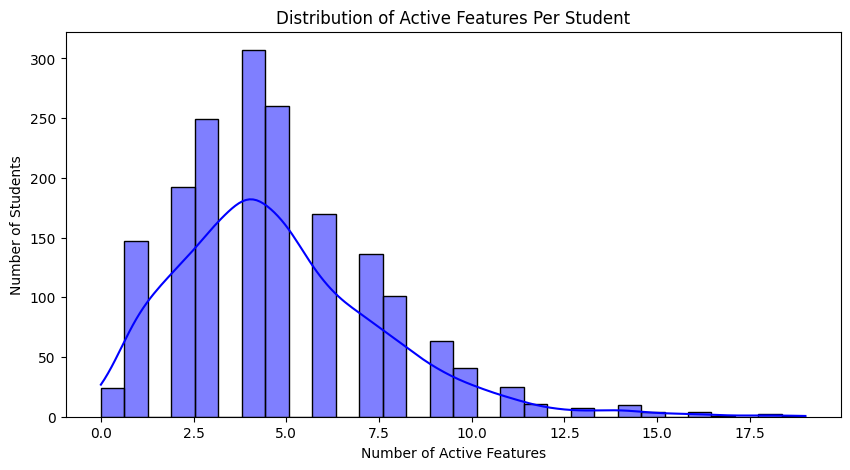

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame
pdf = active_features_df.select(
    "student_pidm", "active_features_filtered", "total_active_features", "course_completion"
).toPandas()

# Explode the list column to analyze feature occurrences
features_exploded = pdf.explode("active_features_filtered")

# Count occurrences of each feature and include course completion
feature_counts = (
    features_exploded.groupby(["active_features_filtered", "course_completion"])
    .size()
    .unstack(fill_value=0)
)

# Ensure columns exist for both 1 (completed) and 0 (not completed)
if 1 not in feature_counts.columns:
    feature_counts[1] = 0
if 0 not in feature_counts.columns:
    feature_counts[0] = 0

# Sort features by total occurrences (both groups combined)
feature_counts["total"] = feature_counts[1] + feature_counts[0]
feature_counts = feature_counts.sort_values("total", ascending=False)

# --- Plot 1: Distribution of Active Features Per Student ---
plt.figure(figsize=(10, 5))
sns.histplot(pdf["total_active_features"], bins=30, kde=True, color="blue")
plt.xlabel("Number of Active Features")
plt.ylabel("Number of Students")
plt.title("Distribution of Active Features Per Student")
plt.show()

<Figure size 1200x600 with 0 Axes>

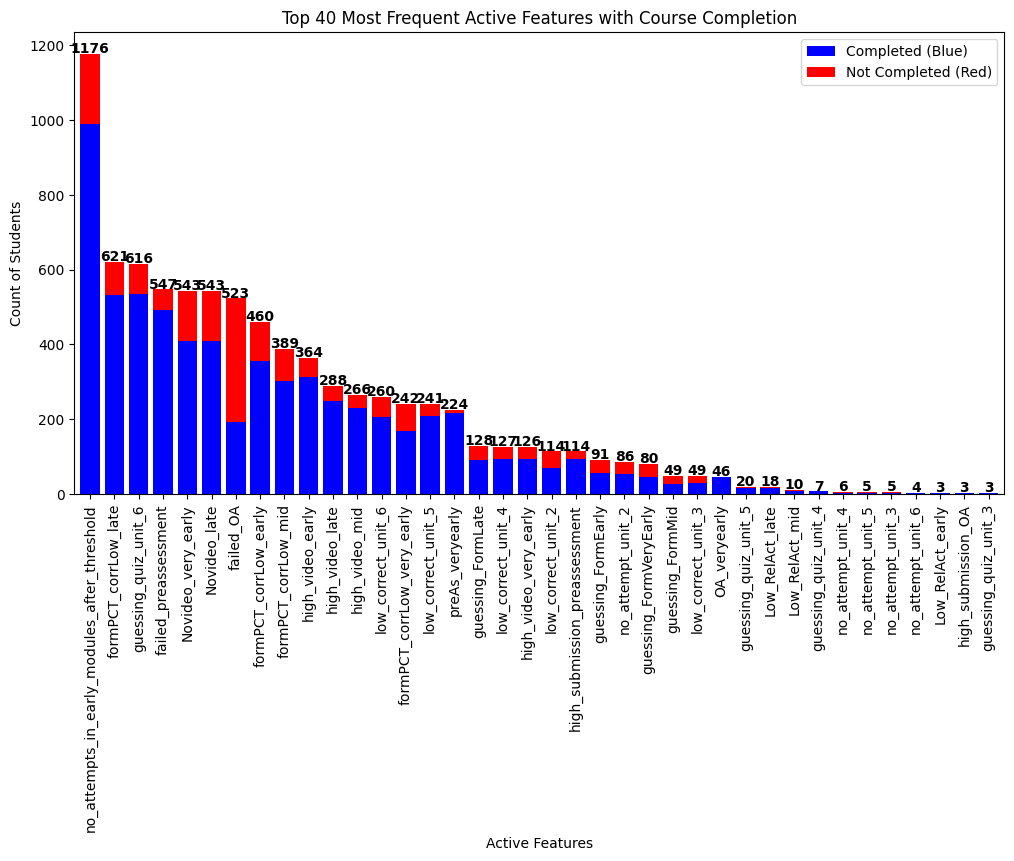

In [0]:
# --- Plot 2: Top 40 Most Frequent Features with Course Completion Coloring ---
plt.figure(figsize=(12, 6))

# Stacked bar chart for completed (blue) and not completed (red)
ax = feature_counts.head(40)[[1, 0]].plot(
    kind="bar",
    stacked=True,
    color=["blue", "red"],
    figsize=(12, 6),
    width=0.8
)

# Move count labels to the **top of the bars**
for index, (completed, not_completed) in enumerate(zip(feature_counts.head(40)[1], feature_counts.head(40)[0])):  
    total = completed + not_completed  # Total height of stacked bars
    
    # Annotate the **total count** at the top of each bar
    ax.text(index, total + 3, str(total), ha='center', fontsize=10, color='black', fontweight='bold')

plt.xlabel("Active Features")
plt.ylabel("Count of Students")
plt.title("Top 40 Most Frequent Active Features with Course Completion")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend(["Completed (Blue)", "Not Completed (Red)"])
plt.show()

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame
pdf = active_features_df.select(
    "student_pidm", "event_timestamp", "active_features_filtered", "total_active_features", "course_completion"
).toPandas()

# Explode the list column to analyze feature occurrences
features_exploded = pdf.explode("active_features_filtered")

# Compute overall non-completion rate (1 - completion rate)
overall_non_completion_rate = 1 - 0.71  # 71% completion means 29% non-completion

# Count occurrences of each feature among all students
total_feature_counts = features_exploded["active_features_filtered"].value_counts().reset_index()
total_feature_counts.columns = ["active_features_filtered", "total_count"]

# Count occurrences of each feature among non-completers (course_completion = 0)
non_completers = features_exploded[features_exploded["course_completion"] == 0]
non_completion_counts = non_completers["active_features_filtered"].value_counts().reset_index()
non_completion_counts.columns = ["active_features_filtered", "non_completion_count"]

# Merge total counts with non-completer counts
feature_stats = pd.merge(total_feature_counts, non_completion_counts, on="active_features_filtered", how="left")
feature_stats["non_completion_count"] = feature_stats["non_completion_count"].fillna(0).astype(int)

# Compute non-completion percentage per feature
feature_stats["non_completion_rate"] = (feature_stats["non_completion_count"] / feature_stats["total_count"]).round(2)

# Add total number of features for reference
# feature_stats["total_features"] = features_exploded["active_features_filtered"].nunique()

# Sort by most frequent features (total_count descending)
feature_stats = feature_stats.sort_values(by="total_count", ascending=False)

# Return the DataFrame
feature_stats.head(35)  # Display the top 30 most frequent features


,active_features_filtered,total_count,non_completion_count,non_completion_rate
0,no_attempts_in_early_modules_after_threshold,1176,188,0.16
1,formPCT_corrLow_late,621,89,0.14
2,guessing_quiz_unit_6,616,82,0.13
3,failed_preassessment,547,57,0.10
4,Novideo_very_early,543,133,0.24
5,Novideo_late,543,133,0.24
6,failed_OA,523,331,0.63
7,formPCT_corrLow_early,460,105,0.23
8,formPCT_corrLow_mid,389,87,0.22
9,high_video_early,364,52,0.14


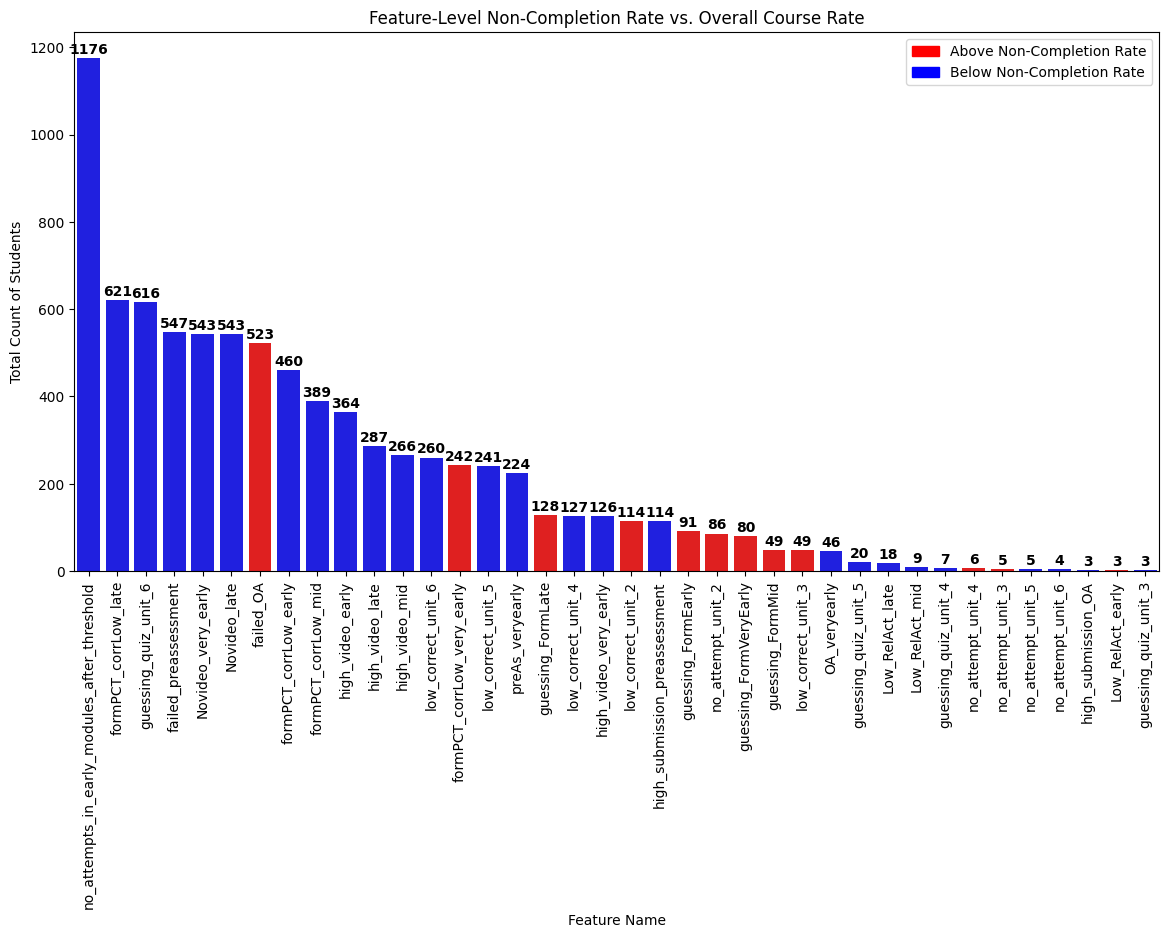

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches  # Import for custom legend

plt.figure(figsize=(14, 7))

# Determine if feature's non-completion rate is above the overall rate
feature_stats["above_avg"] = feature_stats["non_completion_rate"] > overall_non_completion_rate

# Create color mapping: Red = Above Non-Completion Rate, Blue = Below Non-Completion Rate
colors = feature_stats["above_avg"].map({True: "red", False: "blue"})

# Plot bar chart
ax = sns.barplot(
    x=feature_stats["active_features_filtered"].head(40),
    y=feature_stats["total_count"].head(40),  # Total student count per feature
    palette=colors.head(40)
)

# Add count of total students on top of each bar
for i, v in enumerate(feature_stats["total_count"].head(40)):
    ax.text(i, v + 10, str(v), color="black", ha="center", fontsize=10, fontweight="bold")

# Add horizontal line for overall non-completion rate
# plt.axhline(y=overall_non_completion_rate * feature_stats["total_count"].max(), color="black", linestyle="--", label="Overall Non-Completion Rate (29%)")

plt.xlabel("Feature Name")
plt.ylabel("Total Count of Students")
plt.title("Feature-Level Non-Completion Rate vs. Overall Course Rate")
plt.xticks(rotation=90)

# Create legend handles
red_patch = mpatches.Patch(color='red', label='Above Non-Completion Rate')
blue_patch = mpatches.Patch(color='blue', label='Below Non-Completion Rate')

# Add legend
plt.legend(handles=[red_patch, blue_patch], loc="upper right")

plt.show()


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, StringType

window_size = 4  # Define the 4-gram window size

# Step 1: Select active features (where value == 1) and include necessary columns
active_features_df = merged_df_clean.select(
    "student_pidm", "course_completion",
    *[F.when(F.col(feature).cast("int") == 1, F.lit(feature)).otherwise(None).alias(feature) for feature in binary_columns]
)

# Step 2: Create an array of active features per row
active_features_df = active_features_df.withColumn(
    "active_features",
    F.array(*[F.col(feature) for feature in binary_columns])
)

# Step 3: Remove NULL values from the active features array
active_features_df = active_features_df.withColumn(
    "active_features_filtered",
    F.expr("filter(active_features, x -> x IS NOT NULL)")
)

# Step 4: Flatten the collected list so each row contains the **full** feature sequence
flattened_df = active_features_df.withColumn(
    "flat_features",
    F.col("active_features_filtered")
)

# Step 5: Define a UDF to generate ordered 4-gram sequences using a sliding window
def generate_ngrams(features):
    if not features:
        return []

    n = len(features)
    if n < 4:
        return [features]  # Return full sequence if fewer than 4 elements

    return [features[i:i+4] for i in range(n - 3)]  # Generate 4-grams with step 1

generate_ngrams_udf = F.udf(generate_ngrams, ArrayType(ArrayType(StringType())))

# Step 6: Generate **4-gram sequences**
ngrams_df = flattened_df.withColumn(
    "ngrams",
    generate_ngrams_udf("flat_features")  # Apply UDF to generate 4-grams
).select(
    "course_completion", 
    "student_pidm", 
    F.explode("ngrams").alias("window_features")  # Flatten sequences
)

# Step 7: Count occurrences of each unique 4-gram sequence across all students
ngrams_counts_df = ngrams_df.groupBy("window_features").count()


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, StringType

window_size = 4  # Define the 4-gram window size

# Step 1: Select active features (where value == 1) and include necessary columns
active_features_df = merged_df_clean.select(
    "student_pidm", "course_completion",
    *[F.when(F.col(feature).cast("int") == 1, F.lit(feature)).otherwise(None).alias(feature) for feature in binary_columns]
)

# Step 2: Create an array of active features per row
active_features_df = active_features_df.withColumn(
    "active_features",
    F.array(*[F.col(feature) for feature in binary_columns])
)

# Step 3: Remove NULL values from the active features array
active_features_df = active_features_df.withColumn(
    "active_features_filtered",
    F.expr("filter(active_features, x -> x IS NOT NULL)")
)

# Step 4: Flatten the collected list so each row contains the **full** feature sequence
flattened_df = active_features_df.withColumn(
    "flat_features",
    F.col("active_features_filtered")
)

# Step 5: Define a UDF to generate ordered 4-gram sequences using a sliding window
def generate_ngrams(features):
    if not features:
        return []

    n = len(features)
    if n < 4:
        return [features]  # Return full sequence if fewer than 4 elements

    return [features[i:i+4] for i in range(n - 3)]  # Generate 4-grams with step 1

generate_ngrams_udf = F.udf(generate_ngrams, ArrayType(ArrayType(StringType())))

# Step 6: Generate **4-gram sequences**
ngrams_df = flattened_df.withColumn(
    "ngrams",
    generate_ngrams_udf("flat_features")  # Apply UDF to generate 4-grams
).select(
    "course_completion", 
    "student_pidm", 
    F.explode("ngrams").alias("window_features")  # Flatten sequences
)

# Step 7: Count occurrences of each unique 4-gram sequence across all students
ngrams_counts_df = ngrams_df.groupBy("window_features").count()

# Step 8: Count the total number of 4-grams and sequences with <4 features
total_4grams = ngrams_df.filter(F.size("window_features") == 4).count()
total_less_than_4 = ngrams_df.filter(F.size("window_features") < 4).count()

# Step 9: Print the counts
print(f"Total 4-gram sequences: {total_4grams}")
print(f"Total sequences with fewer than 4 features: {total_less_than_4}")

# Show results
# ngrams_counts_df.show(50, truncate=False)


Total 4-gram sequences: 3690
Total sequences with fewer than 4 features: 588


In [0]:
# Ensure unique 4-gram counts per student
ngrams_counts_df = ngrams_df.dropDuplicates(["student_pidm", "window_features"]).groupBy("window_features").count()

# Count distinct 4-gram sequences across all students
unique_4grams_count = ngrams_df.select("window_features").distinct().count()

# Count total 4-gram occurrences
total_4grams = ngrams_df.filter(F.size("window_features") == 4).count()

print(f"Total 4-gram sequences: {total_4grams}")
print(f"Unique 4-gram sequences: {unique_4grams_count}")


Total 4-gram sequences: 3690
Unique 4-gram sequences: 1318


In [0]:
from pyspark.sql import functions as F

# Step 1: Count occurrences of each unique 4-gram sequence grouped by course_completion
ngrams_counts_df = ngrams_df.groupBy("window_features", "course_completion").count()

# Step 2: Apply different frequency cutoff filters
filtered_10 = ngrams_counts_df.filter(F.col("count") >= 10)
filtered_20 = ngrams_counts_df.filter(F.col("count") >= 20)
filtered_40 = ngrams_counts_df.filter(F.col("count") >= 40)
filtered_60 = ngrams_counts_df.filter(F.col("count") >= 60)

# Step 3: Show results for each cutoff
print("🔹 4-gram sequences appearing at least 10 times with course completion status:")
filtered_10.show(50, truncate=False)

print("🔹 4-gram sequences appearing at least 20 times with course completion status:")
filtered_20.show(50, truncate=False)

print("🔹 4-gram sequences appearing at least 40 times with course completion status:")
filtered_40.show(50, truncate=False)

print("🔹 4-gram sequences appearing at least 60 times with course completion status:")
filtered_60.show(50, truncate=False)


🔹 4-gram sequences appearing at least 10 times with course completion status:
+----------------------------------------------------------------------------------------------------------------------+-----------------+-----+
|window_features                                                                                                       |course_completion|count|
+----------------------------------------------------------------------------------------------------------------------+-----------------+-----+
|[high_video_early, high_video_mid, high_video_late, failed_OA]                                                        |0                |12   |
|[low_correct_unit_5, low_correct_unit_6, high_video_early, high_video_mid]                                            |1                |10   |
|[no_attempts_in_early_modules_after_threshold, guessing_quiz_unit_6, low_correct_unit_6, Novideo_very_early]          |1                |19   |
|[low_correct_unit_6, Novideo_very_early, Novideo_la

In [0]:
from pyspark.sql import functions as F

# Step 1: Count occurrences of each unique 4-gram sequence grouped by course_completion
ngrams_counts_df = ngrams_df.groupBy("window_features", "course_completion").count()

# Step 2: Pivot the data to separate completion and non-completion counts
ngrams_pivoted_df = ngrams_counts_df.groupBy("window_features").pivot("course_completion").sum("count")

# Step 3: Rename columns for clarity (0 = Non-Completion, 1 = Completion)
ngrams_pivoted_df = ngrams_pivoted_df.withColumnRenamed("0", "non_completion_count") \
                                     .withColumnRenamed("1", "completion_count")

# Step 4: Fill null values with 0 (some sequences may have only completions or only non-completions)
ngrams_pivoted_df = ngrams_pivoted_df.fillna(0, subset=["non_completion_count", "completion_count"])

# Step 5: Calculate total occurrences and non-completion rate
ngrams_final_df = ngrams_pivoted_df.withColumn("total_count", 
                                               F.col("non_completion_count") + F.col("completion_count")) \
                                   .withColumn("non_completion_rate", 
                                               F.col("non_completion_count") / F.col("total_count"))

# Step 6: Apply different frequency cutoff filters based on total occurrences
filtered_12 = ngrams_final_df.filter(F.col("total_count") >= 12)
filtered_20 = ngrams_final_df.filter(F.col("total_count") >= 20)
filtered_30 = ngrams_final_df.filter(F.col("total_count") >= 30)
filtered_40 = ngrams_final_df.filter(F.col("total_count") >= 40)

# Step 7: Show results for each cutoff
print("🔹 4-gram sequences appearing at least 10 times with non-completion rate:")
filtered_12.show(50, truncate=False)

print("🔹 4-gram sequences appearing at least 20 times with non-completion rate:")
filtered_20.show(50, truncate=False)

print("🔹 4-gram sequences appearing at least 40 times with non-completion rate:")
filtered_30.show(50, truncate=False)

print("🔹 4-gram sequences appearing at least 60 times with non-completion rate:")
filtered_40.show(50, truncate=False)


🔹 4-gram sequences appearing at least 10 times with non-completion rate:
+----------------------------------------------------------------------------------------------------------------------+--------------------+----------------+-----------+-------------------+
|window_features                                                                                                       |non_completion_count|completion_count|total_count|non_completion_rate|
+----------------------------------------------------------------------------------------------------------------------+--------------------+----------------+-----------+-------------------+
|[formPCT_corrLow_early, formPCT_corrLow_late, guessing_FormLate, guessing_quiz_unit_6]                                |3                   |9               |12         |0.25               |
|[guessing_quiz_unit_6, Novideo_very_early, Novideo_late, failed_preassessment]                                        |0                   |13              |13   

In [0]:
from pyspark.sql import functions as F

# Step 1: Count occurrences of each unique 4-gram sequence grouped by course_completion
ngrams_counts_df = ngrams_df.groupBy("window_features", "course_completion").count()

# Step 2: Pivot the data to separate completion and non-completion counts
ngrams_pivoted_df = ngrams_counts_df.groupBy("window_features").pivot("course_completion").sum("count")

# Step 3: Rename columns for clarity (0 = Non-Completion, 1 = Completion)
ngrams_pivoted_df = ngrams_pivoted_df.withColumnRenamed("0", "non_completion_count") \
                                     .withColumnRenamed("1", "completion_count")

# Step 4: Fill null values with 0 (some sequences may have only completions or only non-completions)
ngrams_pivoted_df = ngrams_pivoted_df.fillna(0, subset=["non_completion_count", "completion_count"])

# Step 5: Calculate total occurrences and non-completion rate
ngrams_final_df = ngrams_pivoted_df.withColumn("total_count", 
                                               F.col("non_completion_count") + F.col("completion_count")) \
                                   .withColumn("non_completion_rate", 
                                               F.col("non_completion_count") / F.col("total_count"))

# Step 6: Apply different frequency cutoff filters based on total occurrences
filtered_10 = ngrams_final_df.filter(F.col("total_count") >= 10)
filtered_20 = ngrams_final_df.filter(F.col("total_count") >= 20)
filtered_40 = ngrams_final_df.filter(F.col("total_count") >= 40)
filtered_60 = ngrams_final_df.filter(F.col("total_count") >= 60)

# Step 7: Show results for each cutoff
print("🔹 4-gram sequences appearing at least 10 times with non-completion rate:")
filtered_10.show(50, truncate=False)

print("🔹 4-gram sequences appearing at least 20 times with non-completion rate:")
filtered_20.show(50, truncate=False)

print("🔹 4-gram sequences appearing at least 40 times with non-completion rate:")
filtered_40.show(50, truncate=False)

print("🔹 4-gram sequences appearing at least 60 times with non-completion rate:")
filtered_60.show(50, truncate=False)


🔹 4-gram sequences appearing at least 10 times with non-completion rate:
+----------------------------------------------------------------------------------------------------------------------+--------------------+----------------+-----------+-------------------+
|window_features                                                                                                       |non_completion_count|completion_count|total_count|non_completion_rate|
+----------------------------------------------------------------------------------------------------------------------+--------------------+----------------+-----------+-------------------+
|[Novideo_very_early, Novideo_late, failed_OA]                                                                         |8                   |3               |11         |0.7272727272727273 |
|[guessing_FormVeryEarly, no_attempts_in_early_modules_after_threshold, Novideo_very_early, Novideo_late]              |4                   |6               |10   

In [0]:
from pyspark.sql import functions as F



# Step 2: Calculate the total active features for each row
# Sum all binary columns (where value == 1) for each row
active_features_df = merged_df_clean.withColumn(
    "active_feature_count", sum(F.col(c) for c in binary_columns)
)

# Step 3: Calculate the average active features across all rows
average_active_features = active_features_df.select(
    F.avg("active_feature_count").alias("average_active_features")
).collect()[0]["average_active_features"]

# Step 4: Show the result
print(f"Average active features per row: {average_active_features:.2f}")


Average active features per row: 4.78


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import arrays_overlap, lit

# Step 1: Extract student, course completion, and 4-gram features
student_ngrams_df = ngrams_df.select("student_pidm", "course_completion", "window_features")

# Step 2: Count occurrences of each 4-gram sequence
ngrams_counts_df = ngrams_df.groupBy("window_features").count()

# Step 3: Ensure each 4-gram sequence contains at least 4 features
ngrams_filtered_df = ngrams_counts_df.filter(F.size(F.col("window_features")) >= 4)

# Step 4: Keep only 4-grams that appear at least 12 times
frequent_ngrams_df = ngrams_filtered_df.filter(F.col("count") >= 12)

# Step 5: Collect the final list of valid frequent 4-gram sequences
frequent_ngrams = [row["window_features"] for row in frequent_ngrams_df.collect()]  # Convert Row objects to lists

# Step 6: Create a base DataFrame with all students, course completion status, AND `window_features`
student_features_df = student_ngrams_df.select("student_pidm", "course_completion", "window_features").distinct()

# Step 7: Efficiently add 4-gram features as separate columns
for ngram in frequent_ngrams:
    column_name = "_".join(ngram)  # Convert tuple to a valid column name
    ngram_array = F.array([lit(feature) for feature in ngram])  # Convert to Spark array
    student_features_df = student_features_df.withColumn(column_name, arrays_overlap(F.col("window_features"), ngram_array).cast("int"))

# Step 8: Drop `window_features` column (not needed in final output)
# gram features as separate columns
for ngram in frequent_ngrams:
    column_name = "_".join(ngram)  # Convert tuple to a valid column name
    ngram_array = F.array([lit(feature) for feature in ngram])  # Convert to Spark array
    student_features_df = student_features_df.withColumn(column_name, arrays_overlap(F.col("window_features"), ngram_array).cast("int"))

# Step 8: Drop `window_features` column (not needed in final output)
student_features_df = student_features_df.drop("window_features") 

# Step 9: Add all other binary features as 0
binary_feature_cols = [col for col in merged_df_clean.columns if col not in ["student_pidm", "course_completion", "window_features"]]
for feature in binary_feature_cols:
    student_features_df = student_features_df.withColumn(feature, lit(0))

# Step 10: Show first 10 rows
# student_features_df.show(10, truncate=False)
# 

In [0]:
# student_features_df.show(10, truncate=False)

+------------+-----------------+---------------------------------------------------------------------------------+-------------------------------------------------------------------------+--------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------

In [0]:
# Convert to Pandas DataFrame
student_features_pd = student_features_df.toPandas()

# Show the first few rows
student_features_pd.head()

,student_pidm,course_completion,formPCT_corrLow_early_formPCT_corrLow_late_guessing_FormLate_guessing_quiz_unit_6,guessing_quiz_unit_6_Novideo_very_early_Novideo_late_failed_preassessment,high_video_early_high_video_mid_high_video_late_failed_preassessment,formPCT_corrLow_late_no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_low_correct_unit_6,formPCT_corrLow_very_early_formPCT_corrLow_late_no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6,formPCT_corrLow_late_no_attempts_in_early_modules_after_threshold_Novideo_very_early_Novideo_late,formPCT_corrLow_mid_formPCT_corrLow_late_guessing_quiz_unit_6_low_correct_unit_4,formPCT_corrLow_very_early_formPCT_corrLow_early_formPCT_corrLow_mid_formPCT_corrLow_late,formPCT_corrLow_late_guessing_FormLate_guessing_quiz_unit_6_low_correct_unit_6,no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_low_correct_unit_6_Novideo_very_early,low_correct_unit_6_Novideo_very_early_Novideo_late_failed_preassessment,formPCT_corrLow_early_formPCT_corrLow_mid_formPCT_corrLow_late_guessing_quiz_unit_6,formPCT_corrLow_early_formPCT_corrLow_mid_formPCT_corrLow_late_guessing_FormEarly,formPCT_corrLow_early_formPCT_corrLow_mid_formPCT_corrLow_late_no_attempts_in_early_modules_after_threshold,high_video_very_early_high_video_early_high_video_mid_high_video_late,no_attempt_unit_2_Novideo_very_early_Novideo_late_failed_OA,no_attempt_unit_2_Novideo_very_early_Novideo_late_failed_preassessment,guessing_quiz_unit_6_low_correct_unit_6_Novideo_very_early_Novideo_late,formPCT_corrLow_mid_formPCT_corrLow_late_guessing_FormLate_no_attempts_in_early_modules_after_threshold,formPCT_corrLow_mid_formPCT_corrLow_late_guessing_FormVeryEarly_guessing_FormEarly,low_correct_unit_5_low_correct_unit_6_Novideo_very_early_Novideo_late,no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_low_correct_unit_2_low_correct_unit_4,low_correct_unit_5_low_correct_unit_6_high_video_early_high_video_mid,no_attempts_in_early_modules_after_threshold_high_video_early_high_video_mid_high_video_late,high_video_early_high_video_mid_high_video_late_failed_OA,formPCT_corrLow_early_formPCT_corrLow_late_no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6,no_attempts_in_early_modules_after_threshold_no_attempt_unit_2_Novideo_very_early_Novideo_late,formPCT_corrLow_late_guessing_FormLate_no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6,low_correct_unit_6_Novideo_very_early_Novideo_late_failed_OA,formPCT_corrLow_early_no_attempts_in_early_modules_after_threshold_Novideo_very_early_Novideo_late,no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_preAs_veryearly_failed_preassessment,guessing_quiz_unit_6_high_video_early_high_video_mid_high_video_late,formPCT_corrLow_late_no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_low_correct_unit_2,Novideo_very_early_Novideo_late_preAs_veryearly_failed_preassessment,no_attempts_in_early_modules_after_threshold_Novideo_very_early_Novideo_late_failed_OA,Novideo_very_early_Novideo_late_preAs_veryearly_OA_veryearly,formPCT_corrLow_late_no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_low_correct_unit_5,low_correct_unit_6_high_video_very_early_high_video_early_high_video_mid,...,ReturnM7,ReturnM8,ReturnM9,ReturnM10,ReturnM11,ReturnM12,ReturnM13,ReturnM14,ReturnM15,ReturnM16,ReturnM17,ReturnM18,ReturnM19,ReturnM20,ReturnM21,ReturnM22,ReturnM23,ReturnM24,ReturnM25,ReturnM26,ReturnM1,Low_RelAct_very_early,Low_RelAct_early,Low_RelAct_mid,Low_RelAct_late,high_video_very_early,high_video_early,high_video_mid,high_video_late,event_time,Novideo_very_early,Novideo_early,Novideo_mid,Novideo_late,high_submission_preassessment,preAs_veryearly,failed_preassessment,high_submission_OA,OA_veryearly,failed_OA
0,174697,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12283336,1,0,1,1,0,0,1,0,0

In [0]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Step 7: Assemble features into a single vector column
feature_columns = [col for col in student_features_df.columns if col not in ["student_pidm", "course_completion"]]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
student_features_df = vector_assembler.transform(student_features_df)

# Step 8: Split data into training and testing sets (80% train, 20% test)
train_df, test_df = student_features_df.randomSplit([0.8, 0.2], seed=42)

# Step 9: Train a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="course_completion", maxIter=20)
lr_model = lr.fit(train_df)

# Step 10: Extract logistic regression coefficients
coefficients = lr_model.coefficients.toArray()  # Convert to NumPy array
intercept = lr_model.intercept

# Step 11: Pair coefficients with feature names
feature_coefficients = list(zip(feature_columns, coefficients))

# Step 12: Sort and display top coefficients
sorted_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

print("\n🔹 **Top 50 Most Important Features** 🔹")
for feature, coef in sorted_coefficients[:50]:
    print(f"{feature}: {coef:.6f}")

print(f"\nIntercept: {intercept:.6f}")

# # Step 13: Make predictions
# predictions = lr_model.transform(test_df)

# # Step 14: Evaluate the model
# evaluator = BinaryClassificationEvaluator(labelCol="course_completion", metricName="areaUnderROC")
# auc = evaluator.evaluate(predictions)

# print(f"\n✅ Model AUC: {auc:.4f}")

# # Step 15: Show some predictions
# predictions.select("student_pidm", "course_completion", "prediction", "probability").show(10, truncate=False)



🔹 **Top 30 Most Important Features** 🔹
high_video_early_high_video_mid_high_video_late_failed_OA: -1.567069
high_video_early_high_video_mid_high_video_late_failed_preassessment: 1.560741
no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_preAs_veryearly_failed_preassessment: 1.141496
Novideo_very_early_Novideo_late_preAs_veryearly_OA_veryearly: 1.050809
no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_Novideo_very_early_Novideo_late: 1.011861
no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_low_correct_unit_2_low_correct_unit_4: -0.985497
Novideo_very_early_Novideo_late_high_submission_preassessment_failed_preassessment: -0.677297
formPCT_corrLow_mid_formPCT_corrLow_late_guessing_quiz_unit_6_low_correct_unit_4: 0.676686
formPCT_corrLow_very_early_formPCT_corrLow_early_formPCT_corrLow_mid_formPCT_corrLow_late: 0.674719
formPCT_corrLow_mid_formPCT_corrLow_late_guessing_FormVeryEarly_guessing_FormEarly: -0.673942
formPCT_corrLow_early_form

In [0]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from scipy.stats import norm

# Step 1: Assemble features into a single vector column
feature_columns = [col for col in student_features_df.columns if col not in ["student_pidm", "course_completion"]]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# student_features_df = vector_assembler.transform(student_features_df)

# Step 2: Split data into training and testing sets (80% train, 20% test)
train_df, test_df = student_features_df.randomSplit([0.8, 0.2], seed=42)

# Step 3: Train Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="course_completion", maxIter=20)
lr_model = lr.fit(train_df)

# Step 4: Extract coefficients
coefficients = lr_model.coefficients.toArray()
intercept = lr_model.intercept

# 🔹 **Jackknife Resampling for Standard Errors (Faster Alternative to Bootstrapping)**
num_splits = 5  # Fewer splits = much faster (try 3-5)
split_dfs = train_df.randomSplit([1 / num_splits] * num_splits, seed=42)

jackknife_coefs = []
for split in split_dfs:
    sample_df = train_df.subtract(split)  # Leave out 1 subset
    sample_model = lr.fit(sample_df)
    jackknife_coefs.append(sample_model.coefficients.toArray())

# Convert Jackknife samples to NumPy array & compute standard errors
jackknife_coefs = np.array(jackknife_coefs)
std_errors = np.std(jackknife_coefs, axis=0)  # Standard deviation as estimate of std error

# 🔹 **Calculate p-values using the Wald test**
p_values = [2 * (1 - norm.cdf(abs(coef / std_err))) if std_err > 0 else 1 for coef, std_err in zip(coefficients, std_errors)]

# 🔹 **Sort and display top features**
feature_stats = list(zip(feature_columns, coefficients, std_errors, p_values))
sorted_features = sorted(feature_stats, key=lambda x: abs(x[1]), reverse=True)

print("\n🔹 **Top 30 Most Important Features** 🔹")
print(f"{'Feature':<40} {'Coefficient':<15} {'Std Error':<15} {'P-Value':<15} {'Significant?'}")
print("="*100)
for feature, coef, std_err, p_val in sorted_features[:50]:
    significance = "✅ Yes" if p_val < 0.05 else "❌ No"
    print(f"{feature:<40} {coef:<15.6f} {std_err:<15.6f} {p_val:<15.6f} {significance}")

print(f"\nIntercept: {intercept:.6f}")

# # Step 6: Make predictions
# predictions = lr_model.transform(test_df)

# # Step 7: Evaluate the model
# evaluator = BinaryClassificationEvaluator(labelCol="course_completion", metricName="areaUnderROC")
# auc = evaluator.evaluate(predictions)

# print(f"\n✅ Model AUC: {auc:.4f}")

# # Step 8: Show some predictions
# predictions.select("student_pidm", "course_completion", "prediction", "probability").show(10, truncate=False)



🔹 **Top 30 Most Important Features** 🔹
Feature                                  Coefficient     Std Error       P-Value         Significant?
high_video_early_high_video_mid_high_video_late_failed_OA -1.567069       0.051640        0.000000        ✅ Yes
high_video_early_high_video_mid_high_video_late_failed_preassessment 1.560741        0.124441        0.000000        ✅ Yes
no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_preAs_veryearly_failed_preassessment 1.141496        0.162049        0.000000        ✅ Yes
Novideo_very_early_Novideo_late_preAs_veryearly_OA_veryearly 1.050809        0.083780        0.000000        ✅ Yes
no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_Novideo_very_early_Novideo_late 1.011861        0.126575        0.000000        ✅ Yes
no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_low_correct_unit_2_low_correct_unit_4 -0.985497       0.110469        0.000000        ✅ Yes
Novideo_very_early_Novideo_late_high_subm

In [0]:
# Step 13: Make predictions
predictions = lr_model.transform(test_df)

# Step 14: Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="course_completion", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"\n✅ Model AUC: {auc:.4f}")

# Step 15: Show some predictions
predictions.select("student_pidm", "course_completion", "prediction", "probability").show(10, truncate=False)


✅ Model AUC: 0.7673
+------------+-----------------+----------+----------------------------------------+
|student_pidm|course_completion|prediction|probability                             |
+------------+-----------------+----------+----------------------------------------+
|199100      |1                |1.0       |[0.09367801914641995,0.9063219808535801]|
|259049      |1                |1.0       |[0.12112914091437633,0.8788708590856237]|
|259049      |1                |1.0       |[0.11306335265663885,0.8869366473433612]|
|340815      |1                |1.0       |[0.10672288822027173,0.8932771117797282]|
|462097      |0                |1.0       |[0.07765146846222987,0.9223485315377702]|
|482689      |1                |1.0       |[0.2139969536868419,0.7860030463131581] |
|491774      |0                |0.0       |[0.5908068899157912,0.4091931100842088] |
|530887      |1                |1.0       |[0.17865944883927135,0.8213405511607287]|
|604774      |1                |1.0       |[

In [0]:
predictions.select("student_pidm", "course_completion", "prediction", "probability").show(30, truncate=False)

+------------+-----------------+----------+----------------------------------------+
|student_pidm|course_completion|prediction|probability                             |
+------------+-----------------+----------+----------------------------------------+
|199100      |1                |1.0       |[0.09367801914641995,0.9063219808535801]|
|259049      |1                |1.0       |[0.12112914091437633,0.8788708590856237]|
|259049      |1                |1.0       |[0.11306335265663885,0.8869366473433612]|
|340815      |1                |1.0       |[0.10672288822027173,0.8932771117797282]|
|462097      |0                |1.0       |[0.07765146846222987,0.9223485315377702]|
|482689      |1                |1.0       |[0.2139969536868419,0.7860030463131581] |
|491774      |0                |0.0       |[0.5908068899157912,0.4091931100842088] |
|530887      |1                |1.0       |[0.17865944883927135,0.8213405511607287]|
|604774      |1                |1.0       |[0.09444247259146618,0

In [0]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from scipy.stats import norm

# Step 1: Assemble features into a single vector column
feature_columns = [col for col in student_features_df.columns if col not in ["student_pidm", "course_completion"]]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# student_features_df = vector_assembler.transform(student_features_df)

# Step 2: Split data into training and testing sets (80% train, 20% test)
train_df, test_df = student_features_df.randomSplit([0.8, 0.2], seed=42)

# Step 3: Train Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="course_completion", maxIter=20)
lr_model = lr.fit(train_df)

# Step 4: Extract coefficients
coefficients = lr_model.coefficients.toArray()
intercept = lr_model.intercept

# 🔹 **Jackknife Resampling for Standard Errors (Faster Alternative to Bootstrapping)**
num_splits = 5  # Fewer splits = much faster (try 3-5)
split_dfs = train_df.randomSplit([1 / num_splits] * num_splits, seed=42)

jackknife_coefs = []
for split in split_dfs:
    sample_df = train_df.subtract(split)  # Leave out 1 subset
    sample_model = lr.fit(sample_df)
    jackknife_coefs.append(sample_model.coefficients.toArray())

# Convert Jackknife samples to NumPy array & compute standard errors
jackknife_coefs = np.array(jackknife_coefs)
std_errors = np.std(jackknife_coefs, axis=0)  # Standard deviation as estimate of std error

# 🔹 **Calculate p-values using the Wald test**
p_values = [2 * (1 - norm.cdf(abs(coef / std_err))) if std_err > 0 else 1 for coef, std_err in zip(coefficients, std_errors)]

# 🔹 **Sort and display top features**
feature_stats = list(zip(feature_columns, coefficients, std_errors, p_values))
sorted_features = sorted(feature_stats, key=lambda x: abs(x[1]), reverse=True)

print("\n🔹 **Top 30 Most Important Features** 🔹")
print(f"{'Feature':<40} {'Coefficient':<15} {'Std Error':<15} {'P-Value':<15} {'Significant?'}")
print("="*100)
for feature, coef, std_err, p_val in sorted_features[:50]:
    significance = "✅ Yes" if p_val < 0.05 else "❌ No"
    print(f"{feature:<40} {coef:<15.6f} {std_err:<15.6f} {p_val:<15.6f} {significance}")

print(f"\nIntercept: {intercept:.6f}")

# # Step 6: Make predictions
# predictions = lr_model.transform(test_df)

# # Step 7: Evaluate the model
# evaluator = BinaryClassificationEvaluator(labelCol="course_completion", metricName="areaUnderROC")
# auc = evaluator.evaluate(predictions)

# print(f"\n✅ Model AUC: {auc:.4f}")

# # Step 8: Show some predictions
# predictions.select("student_pidm", "course_completion", "prediction", "probability").show(10, truncate=False)



🔹 **Top 30 Most Important Features** 🔹
Feature                                  Coefficient     Std Error       P-Value         Significant?
high_video_early_high_video_mid_high_video_late_failed_OA -1.567069       0.051640        0.000000        ✅ Yes
high_video_early_high_video_mid_high_video_late_failed_preassessment 1.560741        0.124441        0.000000        ✅ Yes
no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_preAs_veryearly_failed_preassessment 1.141496        0.162049        0.000000        ✅ Yes
Novideo_very_early_Novideo_late_preAs_veryearly_OA_veryearly 1.050809        0.083780        0.000000        ✅ Yes
no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_Novideo_very_early_Novideo_late 1.011861        0.126575        0.000000        ✅ Yes
no_attempts_in_early_modules_after_threshold_guessing_quiz_unit_6_low_correct_unit_2_low_correct_unit_4 -0.985497       0.110469        0.000000        ✅ Yes
Novideo_very_early_Novideo_late_high_subm

In [0]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from scipy.stats import norm  # For p-value calculation

# Step 7: Assemble features into a single vector column
feature_columns = [col for col in student_features_df.columns if col not in ["student_pidm", "course_completion"]]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# student_features_df = vector_assembler.transform(student_features_df)

# Step 8: Split data into training and testing sets (80% train, 20% test)
train_df, test_df = student_features_df.randomSplit([0.8, 0.2], seed=42)

# Step 9: Train initial Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="course_completion", maxIter=20)
lr_model = lr.fit(train_df)

# Step 10: Extract logistic regression coefficients
coefficients = lr_model.coefficients.toArray()
intercept = lr_model.intercept

# Step 11: Bootstrap resampling to estimate standard errors
num_bootstrap_samples = 100  # Number of bootstrap iterations
bootstrap_coefs = []

for _ in range(num_bootstrap_samples):
    sample_df = train_df.sample(withReplacement=True, fraction=1.0, seed=np.random.randint(0, 10000))
    sample_model = lr.fit(sample_df)
    bootstrap_coefs.append(sample_model.coefficients.toArray())

# Step 12: Compute standard errors from bootstrap samples
bootstrap_coefs = np.array(bootstrap_coefs)  # Convert to NumPy array
std_errors = np.std(bootstrap_coefs, axis=0)  # Standard deviation of coefficients

# Step 13: Calculate p-values using the Wald test
p_values = [2 * (1 - norm.cdf(abs(coef / std_err))) if std_err > 0 else 1 for coef, std_err in zip(coefficients, std_errors)]

# Step 14: Pair coefficients, standard errors, and p-values with feature names
feature_stats = list(zip(feature_columns, coefficients, std_errors, p_values))

# Step 15: Sort by absolute coefficient values
sorted_features = sorted(feature_stats, key=lambda x: abs(x[1]), reverse=True)

# Step 16: Display top features & significance
print("\n🔹 **Top 10 Most Important Features** 🔹")
print(f"{'Feature':<40} {'Coefficient':<15} {'Std Error':<15} {'P-Value':<15} {'Significant?'}")
print("="*100)
for feature, coef, std_err, p_val in sorted_features[:10]:
    significance = "✅ Yes" if p_val < 0.05 else "❌ No"
    print(f"{feature:<40} {coef:<15.6f} {std_err:<15.6f} {p_val:<15.6f} {significance}")

print(f"\nIntercept: {intercept:.6f}")

# Step 17: Make predictions
predictions = lr_model.transform(test_df)

# # Step 18: Evaluate the model
# evaluator = BinaryClassificationEvaluator(labelCol="course_completion", metricName="areaUnderROC")
# auc = evaluator.evaluate(predictions)

# print(f"\n✅ Model AUC: {auc:.4f}")

# # Step 19: Show some predictions
# predictions.select("student_pidm", "course_completion", "prediction", "probability").show(10, truncate=False)


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
from pyspark.sql import functions as F

# Step 1: Count occurrences of each unique 4-gram sequence
ngrams_counts_df = ngrams_df.groupBy("window_features").count()

# Step 2: Ensure each 4-gram sequence contains at least 4 features
ngrams_filtered_df = ngrams_counts_df.filter(F.size(F.col("window_features")) >= 4)

# Step 3: Keep only 4-grams that appear at least 10 times
frequent_ngrams_df = ngrams_filtered_df.filter(F.col("count") >= 10)

# Step 4: Collect the final list of frequent 4-gram sequences
frequent_ngrams = frequent_ngrams_df.select("window_features").rdd.flatMap(lambda x: x).collect()
# Print each unique 4-gram sequence
print("Unique 4-gram sequences appearing at least 10 times:")
for seq in frequent_ngrams:
    print(seq)


Unique 4-gram sequences appearing at least 10 times:
['guessing_FormVeryEarly', 'no_attempts_in_early_modules_after_threshold', 'Novideo_very_early', 'Novideo_late']
['formPCT_corrLow_early', 'formPCT_corrLow_late', 'guessing_FormLate', 'guessing_quiz_unit_6']
['high_video_mid', 'high_video_late', 'high_submission_preassessment', 'failed_preassessment']
['guessing_quiz_unit_6', 'Novideo_very_early', 'Novideo_late', 'failed_preassessment']
['high_video_early', 'high_video_mid', 'high_video_late', 'failed_preassessment']
['guessing_quiz_unit_6', 'low_correct_unit_6', 'high_video_early', 'high_video_mid']
['guessing_quiz_unit_6', 'low_correct_unit_2', 'low_correct_unit_5', 'low_correct_unit_6']
['formPCT_corrLow_late', 'no_attempts_in_early_modules_after_threshold', 'guessing_quiz_unit_6', 'low_correct_unit_6']
['formPCT_corrLow_early', 'formPCT_corrLow_mid', 'formPCT_corrLow_late', 'guessing_FormLate']
['formPCT_corrLow_very_early', 'formPCT_corrLow_late', 'no_attempts_in_early_modules_a

In [0]:
from pyspark.sql import functions as F

# Step 1: Count occurrences of each unique 4-gram sequence
ngrams_counts_df = ngrams_df.groupBy("window_features").count()

# Step 2: Ensure each 4-gram sequence contains at least 4 features
ngrams_filtered_df = ngrams_counts_df.filter(F.size(F.col("window_features")) >= 4)

# Step 3: Keep only 4-grams that appear at least 10 times
frequent_ngrams_df1 = ngrams_filtered_df.filter(F.col("count") >= 12)


In [0]:
# Step 4: Count the number of unique frequent 4-gram sequences
num_frequent_ngrams = frequent_ngrams_df1.count()

# Print the result
print(f"Total number of unique 4-gram sequences appearing at least 12 times: {num_frequent_ngrams}")

Total number of unique 4-gram sequences appearing at least 10 times: 45


In [0]:
from pyspark.sql import functions as F

# Step 1: Count distinct 4-feature permutations for all students

# Step 2: Count frequency of each unique 4-feature permutation
ngrams_counts_df = ngrams_df.groupBy("window_features", "course_completion").count()

# Step 3: Apply cutoff filters for 4-gram sequences
filtered_10 = ngrams_counts_df.filter(F.col("count") >= 10)
filtered_25 = ngrams_counts_df.filter(F.col("count") >= 25)
filtered_45 = ngrams_counts_df.filter(F.col("count") >= 45)

# Step 4: Show 4-gram sequences appearing at least 10, 25, and 50 times
print("4-gram sequences appearing at least 10 times:")
filtered_10.show(50, truncate=False)

print("4-gram sequences appearing at least 25 times:")
filtered_25.show(50, truncate=False)

print("4-gram sequences appearing at least 45 times:")
filtered_45.show(50, truncate=False)

# Step 5: Get the **top 20 most frequent** feature combinations
top_feature_combinations = ngrams_counts_df.orderBy(F.desc("count")).limit(20)
print("Top 20 most frequent feature combinations:")
top_feature_combinations.show(truncate=False)

# Step 6: Identify the **most frequently appearing individual features**
individual_features_df = ngrams_counts_df.select(F.explode("window_features").alias("feature"))

# Count occurrences of each individual feature
feature_counts = individual_features_df.groupBy("feature").count()

# Get the **top 20 most frequent** features
top_features = feature_counts.orderBy(F.desc("count")).limit(20)
print("Top 20 most frequent features:")
top_features.show(truncate=False)


4-gram sequences appearing at least 10 times:
+----------------------------------------------------------------------------------------------------------------------+-----------------+-----+
|window_features                                                                                                       |course_completion|count|
+----------------------------------------------------------------------------------------------------------------------+-----------------+-----+
|[high_video_early, high_video_mid, high_video_late, failed_OA]                                                        |0                |12   |
|[low_correct_unit_5, low_correct_unit_6, high_video_early, high_video_mid]                                            |1                |10   |
|[no_attempts_in_early_modules_after_threshold, guessing_quiz_unit_6, low_correct_unit_6, Novideo_very_early]          |1                |19   |
|[low_correct_unit_6, Novideo_very_early, Novideo_late, preAs_veryearly]            

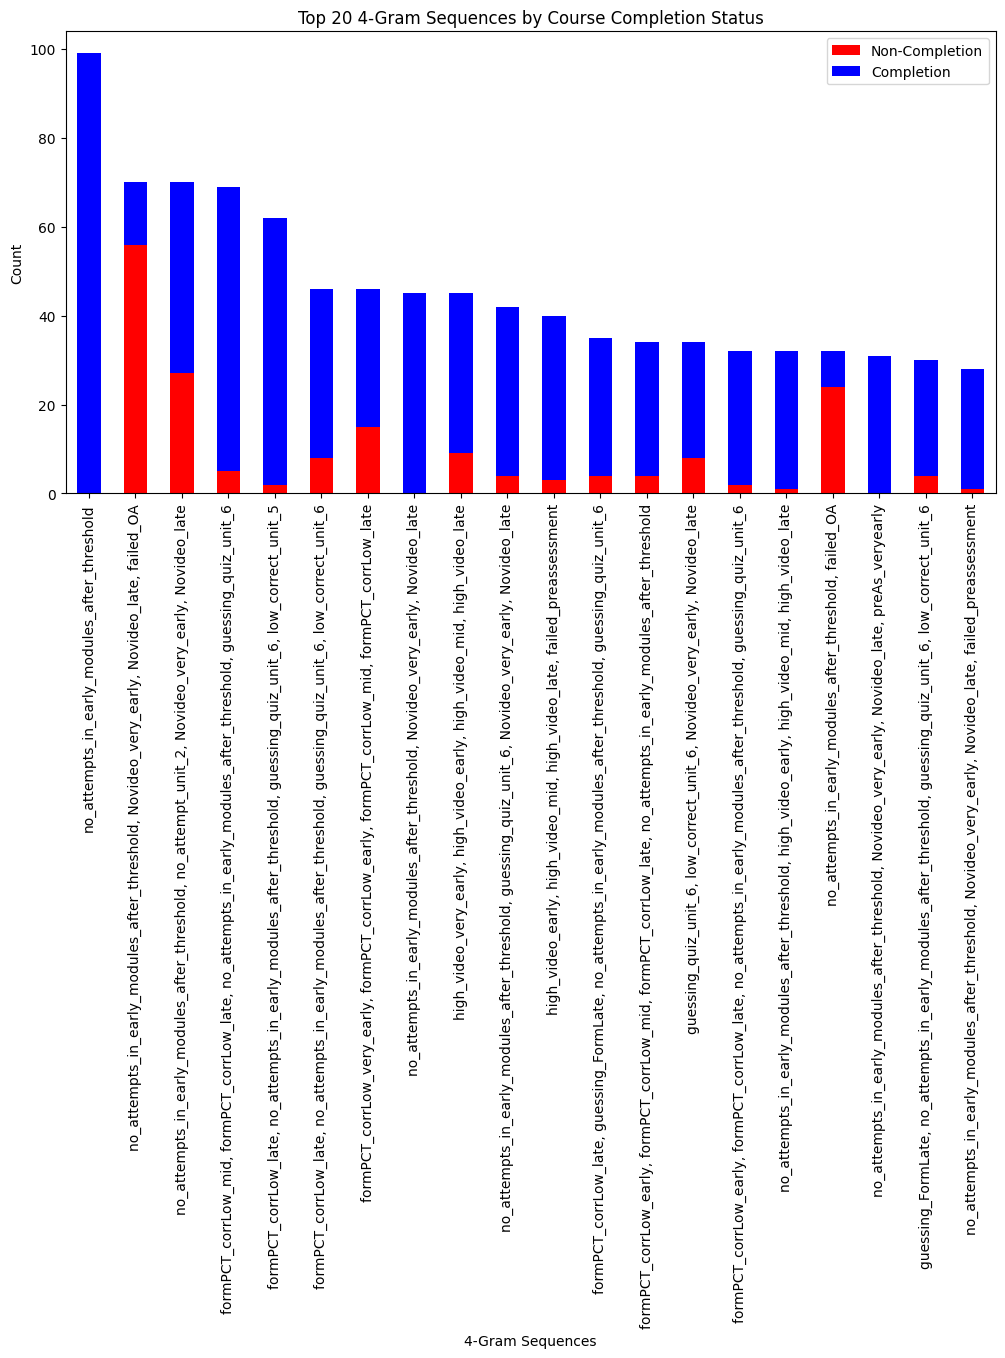

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
ngrams_pandas_df = ngrams_counts_df.toPandas()
ngrams_pandas_df["window_features_str"] = ngrams_pandas_df["window_features"].apply(lambda x: ', '.join(x))
ngrams_pivot = ngrams_pandas_df.pivot(index="window_features_str", columns="course_completion", values="count").fillna(0)

# Pivot data for visualization
# ngrams_pivot = ngrams_pandas_df.pivot(index="window_features", columns="course_completion", values="count").fillna(0)

# Sort by total occurrences
ngrams_pivot["total"] = ngrams_pivot[0] + ngrams_pivot[1]
ngrams_pivot = ngrams_pivot.sort_values(by="total", ascending=False).head(20)

# Plot stacked bar chart
ngrams_pivot[[0, 1]].plot(kind="bar", stacked=True, figsize=(12,6), color=["red", "blue"])
plt.xlabel("4-Gram Sequences")
plt.ylabel("Count")
plt.title("Top 20 4-Gram Sequences by Course Completion Status")
plt.legend(["Non-Completion", "Completion"])
plt.xticks(rotation=90)
plt.show()


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import expr

window_size = 4  # Define the 4-gram window size

# Step 1: Select active features (where value == 1) and include necessary columns
active_features_df = merged_df_clean.select(
    "student_pidm", "event_time", "course_completion",
    *[F.when(F.col(feature).cast("int") == 1, F.lit(feature)).otherwise(None).alias(feature) for feature in binary_columns]
)

# Step 2: Create an array of active features per row
active_features_df = active_features_df.withColumn(
    "active_features",
    F.array(*[F.col(feature) for feature in binary_columns])
)

# Step 3: Remove NULL values from the active features array
active_features_df = active_features_df.withColumn(
    "active_features_filtered",
    F.expr("filter(active_features, x -> x IS NOT NULL)")
)

# Step 4: Define a window partitioned by student and ordered by event_time
window_spec = Window.partitionBy("course_completion", "student_pidm").orderBy("event_time")

# Step 5: Collect active features over time within the window
windowed_df = active_features_df.withColumn(
    "all_active_features",
    F.collect_list("active_features_filtered").over(window_spec)
)

# Step 6: Flatten the collected list so each row contains the full sequence
flattened_df = windowed_df.withColumn(
    "flat_features",
    F.flatten("all_active_features")
)

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StringType
from itertools import combinations

#     F.expr(f"combinations(flat_features, {window_size})")  # Generates all possible 4-feature permutationsons
def generate_combinations(features):
    if features is None:
        return []
    return list(map(list, combinations(features, 4)))  # Convert tuples to lists

# Register as a Spark UDF
generate_combinations_udf = F.udf(generate_combinations, ArrayType(ArrayType(StringType())))

# Step 7: Generate all permutations of 4 active features
permutation_df = flattened_df.withColumn(
    "feature_combinations",
    generate_combinations_udf("flat_features")  # Apply UDF to generate 4-grams
).select(
    "course_completion", "student_pidm", F.explode("feature_combinations").alias("window_features")
).filter(F.size("window_features") == 4)  # Ensure only 4-feature combinations are kept


# Step 8: Show results
# permutation_df.show(50, truncate=False)


In [0]:
filtered_df = active_features_df.select("event_time", "active_features_filtered")
filtered_df.write.mode("overwrite").parquet("filtered_features.parquet")


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-4393098779059443>, line 74
     71     return pd.DataFrame(results)
     73 # Call the Function
---> 74 student_results = check_high_skipping_per_student(pandas_df)

NameError: name 'pandas_df' is not defined

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import expr

window_size = 4  # Define the window size

# Step 1: Select active features (features where value == 1) and include necessary columns
active_features_df = merged_df_clean.select(
    "student_pidm", "event_time", "course_completion",
    *[F.when(F.col(feature) == 1, F.lit(feature)).otherwise(None).alias(feature) for feature in binary_columns]
)

# Step 2: Create an array of active features
active_features_df = active_features_df.withColumn(
    "active_features",
    F.array(*[F.col(feature) for feature in binary_columns])
)

# Step 3: Filter out NULL values from the active features array
active_features_df = active_features_df.withColumn(
    "active_features_filtered",
    F.expr("filter(active_features, x -> x IS NOT NULL)")
)

# Step 4: Apply window slicing (4-gram)
windowed_df = active_features_df.withColumn(
    "window_features",
    expr(f"slice(active_features_filtered, 1, {window_size})")  # Slice the first 4 active features
)

# Step 5: Show the results
windowed_df.select("student_pidm", "event_time", "course_completion", "window_features").show(50, truncate=False)


+------------+--------------------------+-----------------+------------------------------------------------------------------------------------------------------------+
|student_pidm|event_time                |course_completion|window_features                                                                                             |
+------------+--------------------------+-----------------+------------------------------------------------------------------------------------------------------------+
|46537       |2024-08-02 21:30:23.56387 |1                |[failed_OA]                                                                                                 |
|174697      |2024-08-02 12:41:11.188673|1                |[preAs_veryearly]                                                                                           |
|199100      |2024-09-04 01:22:42.654418|1                |[no_attempts_in_early_modules_after_threshold]                                                  